In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
label_names = np.asarray(['highway','insidecity','tallbuilding','street','forest','coast','mountain','opencountry'])
folder = "./LabelMe/"

### Load Data and preprocess

In [4]:
X_train_vgg16 = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

X_val_vgg16 = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

X_test_vgg16 = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",X_train_vgg16.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


In [5]:
Xstd_train = X_train_vgg16
Xstd_val = X_val_vgg16
Xstd_test = X_test_vgg16

In [6]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=False,with_std=False)  #do it ??
std.fit(X_train_vgg16)
Xstd_train = std.transform(X_train_vgg16)
Xstd_val = std.transform(X_val_vgg16)
Xstd_test = std.transform(X_test_vgg16)
Xstd_train.shape

(1000, 512)

### Load annotations / Generate

In [6]:
from code.representation import *
from code.utils import *

# data from Amazon Mechanical Turk
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Remove 18 annotators that do not annotate on this set 
Shape (data,annotators):  (1000, 59)
Classes:  8


In [17]:
#every annotation is one annotator
total_annotations = T_weights.sum(axis=0)
new_annotations = np.ones((N, total_annotations),dtype='int16')*-1
t_aux = 0
for i in range(y_obs.shape[0]):
    for t in range(y_obs.shape[1]):
        if y_obs[i,t] != -1:
            new_annotations[i,t_aux] = y_obs[i,t]
            t_aux+=1
new_annotations.shape

(1000, 2547)

In [27]:
#perturbe annotations by annotators
total_annotations = T_weights.sum(axis=0)

new_annotations = np.ones((N, 20000),dtype='int16')*-1
new_annotations[:,:T] = y_obs

for new_t in range(T,new_annotations.shape[1]):
    t_select = np.random.randint(T)
    
    t_aux = np.random.poisson(10) #1 #values left-- change value to remove few annotators
    mask_bin = (np.random.multinomial(t_aux, np.tile(1./N,N)) != 0)
    
    new_annotator = mask_bin*(y_obs[:,t_select]+1) -1 #new annotations of annotator generated
    new_annotations[:,new_t] = new_annotator
    
T_weights = np.sum(new_annotations != -1,axis=0) #distribucion de anotaciones
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
new_annotations = new_annotations[:,T_weights!=0]
new_annotations.shape

Remove 13928 annotators that do not annotate on this set 


(1000, 6072)

In [30]:
np.savetxt(folder+"answers_v3.txt",new_annotations, delimiter=",", fmt="%i")

In [7]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        #how to fill where she not annotate?? -- 
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
        #confe_matrix[t,value,:] = mean_replace #Ours
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7777778 , 0.11111111, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.78571427, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.23076923, 0.7692308 , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         1.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.05555556,
         0.22222222, 0.5555556 ]],

       [[1.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.125     , 0.125     , 0.125     , ..., 0.125     ,
         0.125     , 0.125     ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        ,
         0.        , 0.        ],
        [0. 

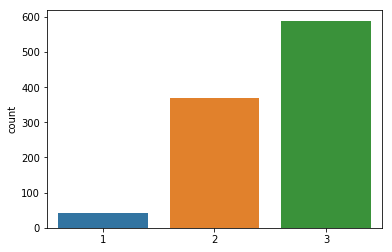

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


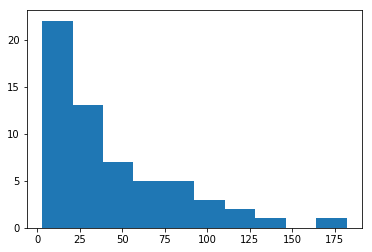

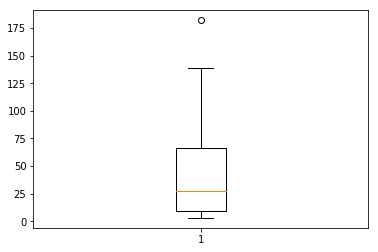

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  43.16949152542373


In [8]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [9]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [10]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Trained IDeal Model, Epochs to converge = 13


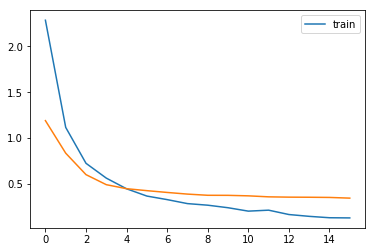

In [46]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

### Infer Labels (without predictive model)

In [11]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.138425 sec
Representation for DS in 0.108595 sec
Estimation MV in 0.000303 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -2837.162198697235
2 	 -2760.5637733289814 	0.0216	0.166209	0.026998
3 	 -2734.590823208355 	0.0124	0.062463	0.009409
4 	 -2723.3804042488773 	0.0073	0.061532	0.004099
5 	 -2717.719491028206 	0.0045	0.054811	0.002079
6 	 -2714.517475271211 	0.0031	0.043390	0.001178
7 	 -2712.6729434426734 	0.0022	0.033013	0.000680
8 	 -2711.508835118107 	0.0017	0.026319	0.000429
Class marginals
[0.08 0.11 0.14 0.11 0.14 0.14 0.17 0.09]
Estimation for DS in 2.092380 sec


In [12]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.769
ACC D&S on train: 0.804


In [13]:
#check ds with  theones come with data
aux = np.loadtxt("./LabelMe/answers_DS.txt",dtype='int')
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train)) #calculated by Rodrigues (until converge)
print("Similaririty between ours and his: ",np.mean(ds_labels.argmax(axis=1) == aux))

ACC D&S on train: 0.804
Similaririty between ours and his:  0.966


In [14]:
model_mvsoft = keras.models.clone_model(model_UB)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 8


In [19]:
model_mvhard = keras.models.clone_model(model_UB)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 16


In [21]:
model_ds = keras.models.clone_model(model_UB)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 9


### Raykar Model (joint predict model)

In [25]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (1000, 2547, 8)


In [26]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",128,1,BatchN=False,drop=0.5) #otro

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.46 sec)	logL: -4441.701	
Iter 2/50 
M step: done,  E step: done //  (in 0.26 sec)	logL: -4198.188	Tol1: 0.05482	Tol2: 0.01469	
Iter 3/50 
M step: done,  E step: done //  (in 0.27 sec)	logL: -4108.247	Tol1: 0.02142	Tol2: 0.00528	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.13 sec)	logL: -4463.614	
Iter 2/50 
M step: done,  E step: done //  (in 0.25 sec)	logL: -4194.899	Tol1: 0.06020	Tol2: 0.01544	
Iter 3/50 
M step: done,  E step: done //  (in 0.26 sec)	logL: -4082.526	Tol1: 0.02679	Tol2: 0.00575	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 1.10 sec)	logL: -4483.836	
Iter 2/50 
M step: done,  E step: done //  (in 0.26 sec)	logL: 

In [27]:
Z_train_p = raykarMC.get_predictions(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.get_predictions(Xstd_test)

Bayesian gaussian mixture say is 20 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt

DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (5197, 4)


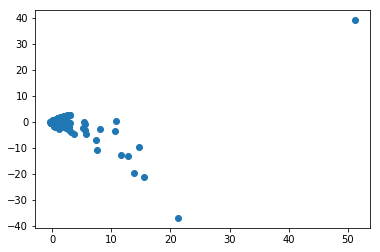

In [12]:
## cluster annotations?
from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)

std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

### Our Proposed

In [10]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [11]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups


#get our representation 
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 2 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 [0 0 0 ... 0 0 2]]
shape: (1000, 8)


Normalized entropy (0-1) of repeats annotations: 0.11212816116784208


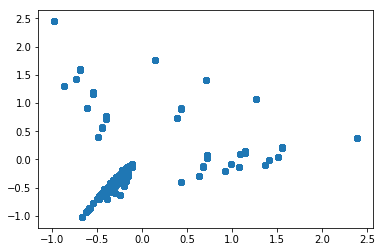

In [10]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import *
predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.005396 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7649964  0.35427967 0.05306005 0.08938941 0.32689986]
Alphas:  (5,)
MV init:  (1000, 8)
Betas:  (5, 8, 8)
Q estimate:  (1000, 8, 5, 8)
Iter 1/0
M step: done,  E step: done //  (in 0.57 sec)	logL: -7404.934	
Finished training!


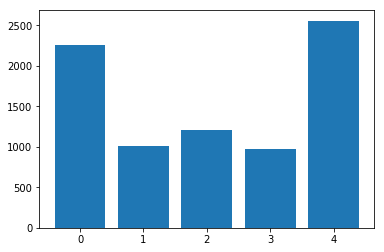

<BarContainer object of 5 artists>

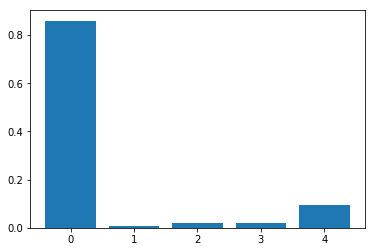

In [16]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=5,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [31]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        gMixture_Global.lambda_random = True 
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003649 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.29]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -3260.276	
Iter 2/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -2203.735	Tol1: 0.32406	Tol2: 0.70936	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1987.212	Tol1: 0.09825	Tol2: 0.15927	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1902.811	Tol1: 0.04247	Tol2: 0.11973	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.444	Tol1: 0.02594	Tol2: 0.06754	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1775.781	Tol1: 0.04190	Tol2: 0.05046	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL:

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Remember to prior bethas
Doing clustering...Done!
Get init alphas in 0.003971 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.59]
Alphas:  (1,)
MV init:  (1000, 8)
Betas:  (1, 8, 8)
Q estimate:  (1000, 8, 1, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -3011.392	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2115.873	Tol1: 0.29738	Tol2: 0.39124	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1924.810	Tol1: 0.09030	Tol2: 0.18874	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1853.941	Tol1: 0.03682	Tol2: 0.14168	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1779.691	Tol1: 0.04005	Tol2: 0.10433	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1732.332	Tol1: 0.02661	Tol2: 0.07472	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL:

/users/fmena/MixtureofGroups/code/utils.py:285: RuntimeWarning: invalid value encountered in true_divide
  entropy_values = [entropy(value)/np.log(len(value)) for value in probas_Mchange]


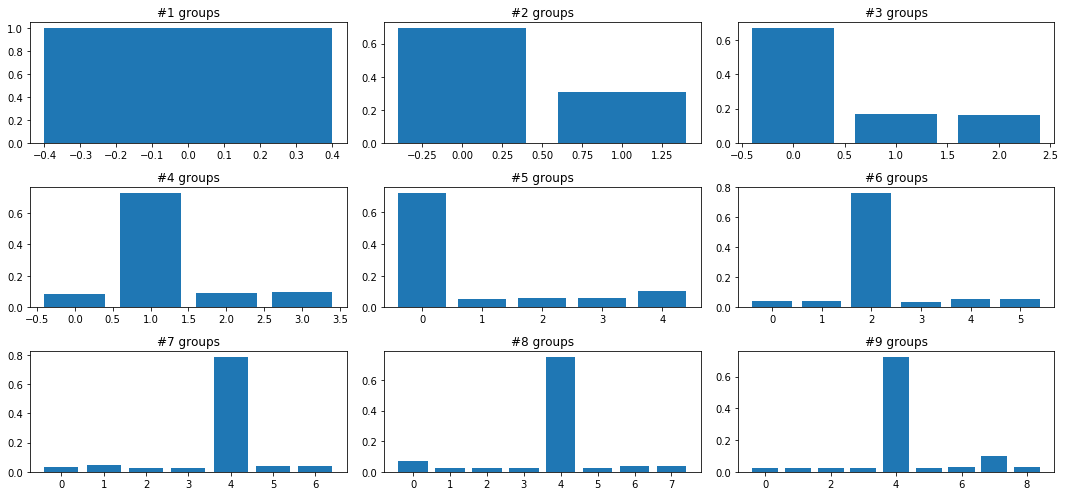

<Figure size 1080x360 with 0 Axes>

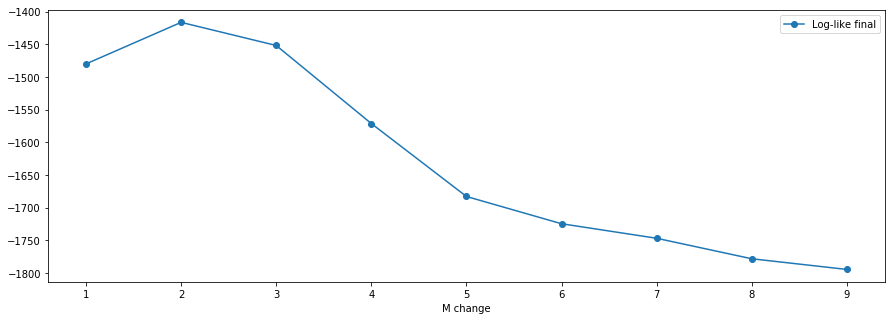

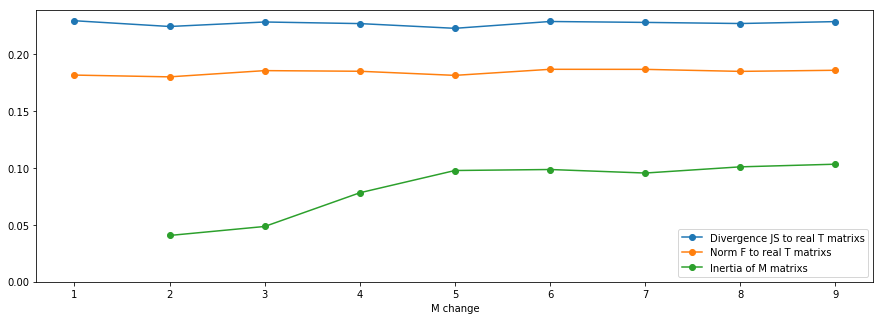

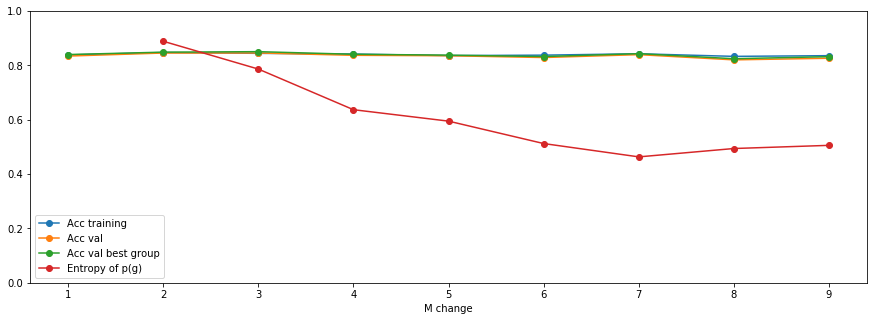

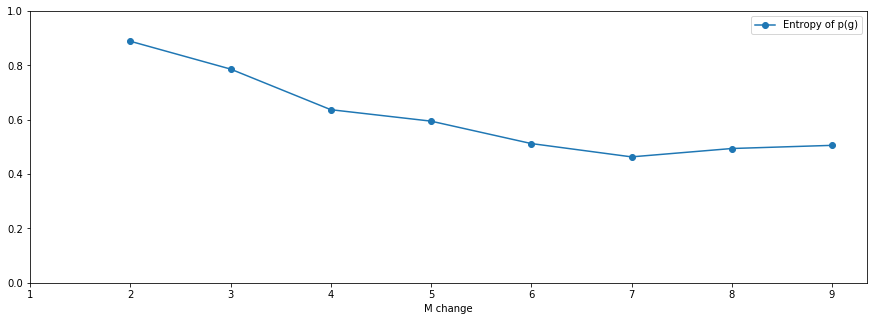

In [32]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [17]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

59


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0        1              1              1                   1   
1        2              1              1                   1   
2        3              1              1                   1   
3        4              2              1                   1   
4        5              1              1                   1   
5        6              1              1                   1   
6        7              2              1                   1   
7        8              2              2                   1   
8        9              2              1                   1   

   Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                1                                1  
1                                1                                1  
2                                1                                1  
3                                2                                1  
4                                1                                1  
5                                1                                1  
6                                2                                1  
7                                2                                2  
8                                2                                1

1, 2 o 3...

In [12]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [13]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",128,1,BatchN=False,drop=0.5)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

gMixture_Global.lambda_random = False 
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005034 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.78 sec)	logL: -3436.097	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2429.970	Tol1: 0.29281	Tol2: 0.33694	Tol3: 0.05765	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2163.031	Tol1: 0.10985	Tol2: 0.13640	Tol3: 0.21582	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2020.330	Tol1: 0.06597	Tol2: 0.08778	Tol3: 0.23459	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1918.876	Tol1: 0.05022	Tol2: 0.06404	Tol3: 0.22911	
Iter 6/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1848.190	Tol1: 0.03684	Tol2: 0.04441	Tol3: 0.21804	
Iter 7/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1777.939	Tol1: 0.03801	Tol2: 0.03349	Tol3: 0.19098	
Iter 8

M step: done,  E step: done //  (in 0.06 sec)	logL: -1679.510	Tol1: 0.03071	Tol2: 0.01859	Tol3: 0.13630	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1632.295	Tol1: 0.02811	Tol2: 0.01429	Tol3: 0.09353	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.004101 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3005.752	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2160.156	Tol1: 0.28133	Tol2: 0.26765	Tol3: 0.07139	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1990.724	Tol1: 0.07843	Tol2: 0.12809	Tol3: 0.25867	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1888.549	Tol1: 0.05133	Tol2: 0.07973	Tol3: 0.23126	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1806.444	Tol1: 0.04347	Tol2: 0.05050	Tol3: 0.21884	
Iter 6/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.05 sec)	logL: -1910.830	Tol1: 0.03954	Tol2: 0.06572	Tol3: 0.21578	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1847.707	Tol1: 0.03303	Tol2: 0.04668	Tol3: 0.19642	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1798.574	Tol1: 0.02659	Tol2: 0.02830	Tol3: 0.17717	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.003761 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.52 sec)	logL: -3421.633	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2338.223	Tol1: 0.31664	Tol2: 0.37640	Tol3: 0.19564	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2028.680	Tol1: 0.13238	Tol2: 0.17648	Tol3: 0.23763	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1895.713	Tol1: 0.06554	Tol2: 0.11728	Tol3: 0.25238	
Iter 5/50
M step: done,  E step: done

In [26]:
Z_train_p = gMixture_Global.get_predictions(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

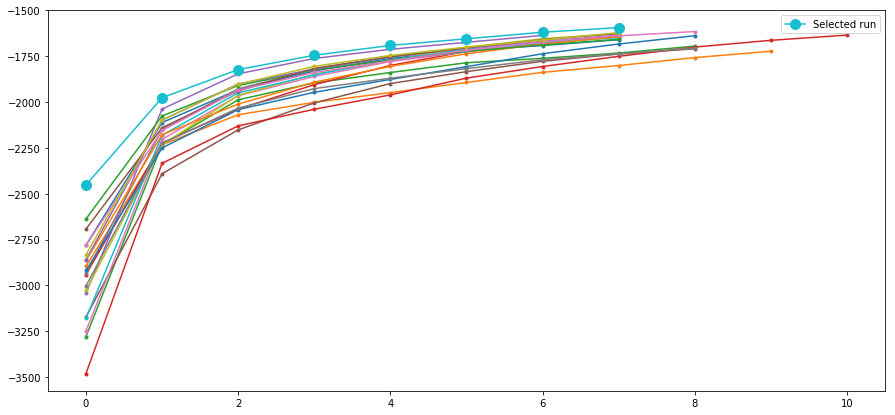

In [16]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [14]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (59, 59)


shape of annotator representation (T, R_t)= (59, 8)


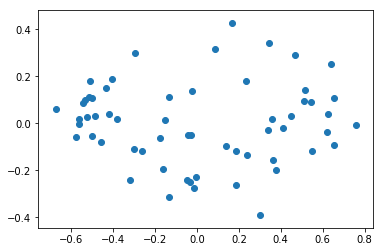

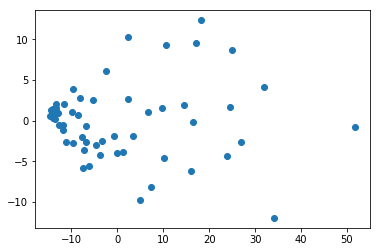

array([[ 7., 17., 10., 11., 15., 13., 25., 10.],
       [ 2.,  0.,  0.,  3.,  1.,  2.,  2.,  2.],
       [ 4.,  9., 10.,  8.,  4., 11., 16.,  8.],
       [ 6.,  0., 11., 11.,  3.,  4., 11.,  4.],
       [ 4., 11., 15., 10., 20.,  4., 17.,  4.],
       [ 4.,  6., 12.,  5.,  9., 10.,  9.,  7.],
       [ 9., 15.,  8.,  7., 11., 16., 14., 11.],
       [ 1.,  0., 10.,  5.,  2., 10.,  5.,  2.],
       [ 2.,  4.,  2.,  3.,  3.,  4.,  4.,  3.],
       [ 2., 11.,  8.,  4., 13., 10., 15.,  5.],
       [11., 16., 19., 14., 25., 10., 14., 11.],
       [11., 13., 15., 15., 16., 15., 20.,  5.],
       [ 1.,  6.,  0.,  3.,  2.,  2.,  2.,  1.],
       [ 2.,  9.,  2.,  0.,  4.,  1.,  4.,  1.],
       [ 4.,  8.,  2.,  0.,  6.,  2.,  4.,  2.],
       [ 4., 18., 10.,  3.,  6.,  6., 13.,  4.],
       [ 6.,  3., 15., 16., 16., 22., 19., 13.],
       [ 6.,  4., 15., 20.,  7., 14., 18.,  8.],
       [ 5.,  6., 13., 18.,  8., 10., 21.,  7.],
       [ 9., 26., 11., 14., 20., 25., 20., 14.],
       [ 7., 23., 23

In [15]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [16]:
#different M_seted??
M_seted = 3

In [17]:
gMixture_Ind2 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind2.define_model("mlp",128,1,BatchN=False,drop=0.5)
#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
#gMixture_Ind.define_model_group("keras_shallow", T, M_seted,embed=True, embed_M=A) #pareciera ser necesario pr-init

logL_hists,i = gMixture_Ind2.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000407 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.48 sec)	logL: -1888.582	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1721.554	Tol1: 0.08844	Tol2: 0.18565	
Iter 3/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1603.993	Tol1: 0.06829	Tol2: 0.08069	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -1537.053	Tol1: 0.04173	Tol2: 0.05193	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1496.598	Tol1: 0.02632	Tol2: 0.02898	
Finished training!
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000401 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs..

M step: done,  E step: done //  (in 0.05 sec)	logL: -1448.412	Tol1: 0.01983	Tol2: 0.01925	
Finished training!
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000407 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.47 sec)	logL: -1919.861	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1744.690	Tol1: 0.09124	Tol2: 0.17660	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1621.291	Tol1: 0.07073	Tol2: 0.07529	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1550.967	Tol1: 0.04337	Tol2: 0.04675	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1494.592	Tol1: 0.03635	Tol2: 0.04243	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1459.202	Tol1: 0.02368	Tol2: 0.02408	
Finished training!
Initializing new EM...
A 

M step: done,  E step: done //  (in 0.55 sec)	logL: -1834.245	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1684.942	Tol1: 0.08140	Tol2: 0.17155	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1578.994	Tol1: 0.06288	Tol2: 0.08170	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1531.875	Tol1: 0.02984	Tol2: 0.04712	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1496.346	Tol1: 0.02319	Tol2: 0.03048	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1458.566	Tol1: 0.02525	Tol2: 0.02861	
Finished training!
Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.000397 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.53 sec)	logL: -1924.050	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1738.545	

In [16]:
Z_train_p = gMixture_Ind2.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind2.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind2.get_predictions_g(T_idx_unique) 

In [18]:
gMixture_Ind3 = GroupMixtureInd(Xstd_train.shape[1:],Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("mlp",16,1,BatchN=False,drop=0.2)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(20,Xstd_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=15,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000261 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.94 sec)	logL: -2837.798	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -2472.754	Tol1: 0.12864	Tol2: 0.29548	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2231.944	Tol1: 0.09739	Tol2: 0.10462	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2069.756	Tol1: 0.07267	Tol2: 0.06320	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1950.425	Tol1: 0.05765	Tol2: 0.05274	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1860.352	Tol1: 0.04618	Tol2: 0.05051	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1780.5

M step: done,  E step: done //  (in 0.05 sec)	logL: -2529.478	Tol1: 0.07845	Tol2: 0.06143	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2350.307	Tol1: 0.07083	Tol2: 0.05552	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2218.203	Tol1: 0.05621	Tol2: 0.04978	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2131.707	Tol1: 0.03899	Tol2: 0.04245	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2053.081	Tol1: 0.03688	Tol2: 0.03930	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1970.838	Tol1: 0.04006	Tol2: 0.03707	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1900.479	Tol1: 0.03570	Tol2: 0.03643	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1837.142	Tol1: 0.03333	Tol2: 0.04229	
Iter 12/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1788.407	Tol1: 0.02653	Tol2: 0.04435	
Iter 13/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1732.482	Tol1: 0.03127	Tol2: 0.037

M step: done,  E step: done //  (in 0.91 sec)	logL: -3292.109	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2960.225	Tol1: 0.10081	Tol2: 0.32045	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -2676.100	Tol1: 0.09598	Tol2: 0.10927	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2482.685	Tol1: 0.07227	Tol2: 0.07265	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2350.672	Tol1: 0.05317	Tol2: 0.05813	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2230.127	Tol1: 0.05128	Tol2: 0.05849	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2143.865	Tol1: 0.03868	Tol2: 0.05380	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2055.391	Tol1: 0.04127	Tol2: 0.03873	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1984.299	Tol1: 0.03459	Tol2: 0.03503	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1909.250	Tol1: 0.03782	Tol2: 0.03177	
Iter 11/50
M step: done,  E

M step: done,  E step: done //  (in 0.07 sec)	logL: -2378.961	Tol1: 0.12313	Tol2: 0.30511	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2155.980	Tol1: 0.09373	Tol2: 0.10807	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2004.573	Tol1: 0.07023	Tol2: 0.06800	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1903.120	Tol1: 0.05061	Tol2: 0.06165	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1833.273	Tol1: 0.03670	Tol2: 0.05332	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1784.733	Tol1: 0.02648	Tol2: 0.05525	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1728.066	Tol1: 0.03175	Tol2: 0.04960	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1680.270	Tol1: 0.02766	Tol2: 0.05812	
Iter 10/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1636.955	Tol1: 0.02578	Tol2: 0.03812	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1603.563	Tol1: 0.02040	Tol2: 0.04017

M step: done,  E step: done //  (in 0.05 sec)	logL: -1508.861	Tol1: 0.01683	Tol2: 0.03494	
Iter 21/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1488.011	Tol1: 0.01382	Tol2: 0.03203	
Iter 22/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1471.255	Tol1: 0.01126	Tol2: 0.02708	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000245 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.91 sec)	logL: -3186.873	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2825.907	Tol1: 0.11327	Tol2: 0.30998	
Iter 3/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2582.018	Tol1: 0.08630	Tol2: 0.10323	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2408.724	Tol1: 0.06712	Tol2: 0.07395	
Iter 5/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.05 sec)	logL: -1784.233	Tol1: 0.01648	Tol2: 0.03057	
Iter 15/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1729.125	Tol1: 0.03089	Tol2: 0.02993	
Iter 16/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1692.248	Tol1: 0.02133	Tol2: 0.03473	
Iter 17/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1650.612	Tol1: 0.02460	Tol2: 0.03032	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1630.074	Tol1: 0.01244	Tol2: 0.02937	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000242 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *g* on 15 epochs... Done!
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (1000, 8)
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -3479.811	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -3108.277	Tol1: 0.10677	Tol2: 0.35664	
Iter 3/50
M step: done,  E step: do

In [20]:
Z_train_p = gMixture_Ind3.get_predictions_z(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

### Compare trained models

In [19]:
#Import it:
from code.evaluation import Evaluation_metrics

In [14]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ===  ==========  ============
  ..         Accuracy    F1 (micro)
====  ===  ==========  ============
   0  All       0.955         0.955
====  ===  ==========  ============
Test
A result
 ====  ===  ==========  ============
  ..         Accuracy    F1 (micro)
====  ===  ==========  ============
   0  All    0.906566      0.906566
====  ===  ==========  ============


In [ ]:
#upper bound global confusion matrix..
prob_Yz = generate_confusionM(Z_train_pred, label_I.y_obs_repeat)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


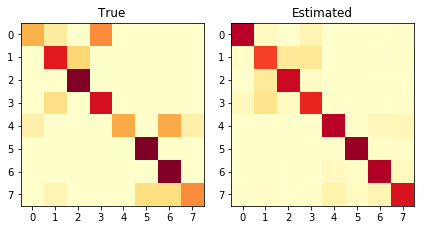

JS divergence: 0.1224	Norm Frobenius: 0.1300


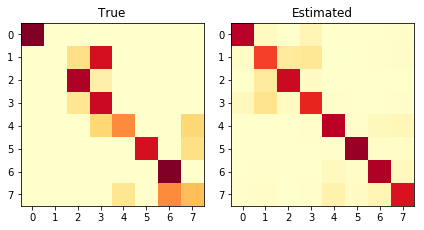

JS divergence: 0.1770	Norm Frobenius: 0.1613


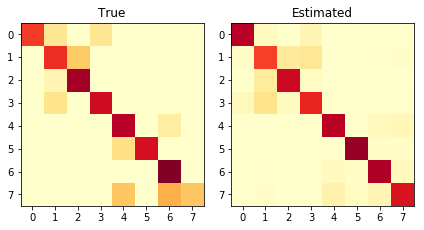

JS divergence: 0.0879	Norm Frobenius: 0.0974


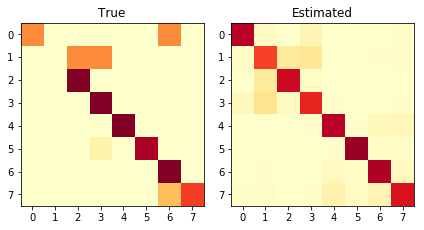

JS divergence: 0.1755	Norm Frobenius: 0.1467


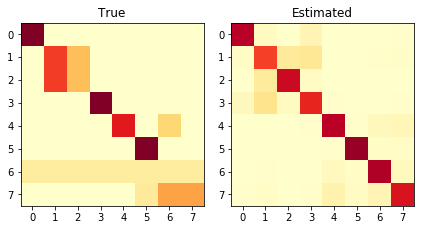

JS divergence: 0.1830	Norm Frobenius: 0.1652


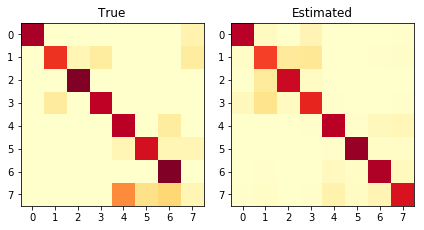

JS divergence: 0.1154	Norm Frobenius: 0.1195


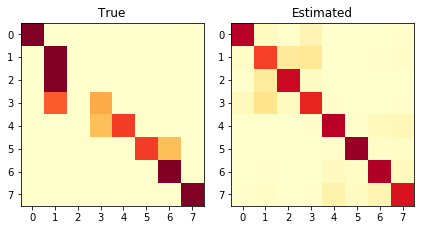

JS divergence: 0.2061	Norm Frobenius: 0.1893


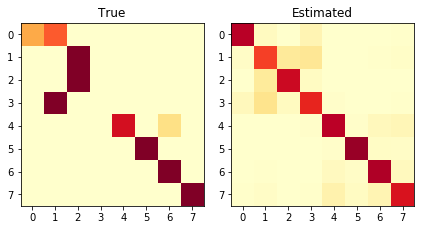

JS divergence: 0.2528	Norm Frobenius: 0.2205


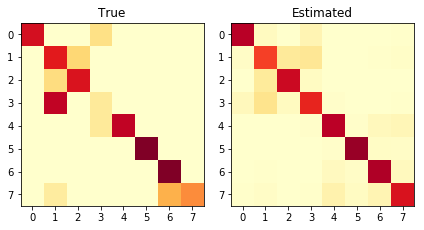

JS divergence: 0.1182	Norm Frobenius: 0.1318


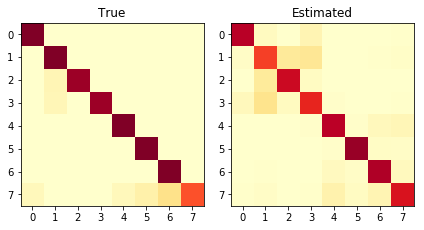

JS divergence: 0.0730	Norm Frobenius: 0.0744


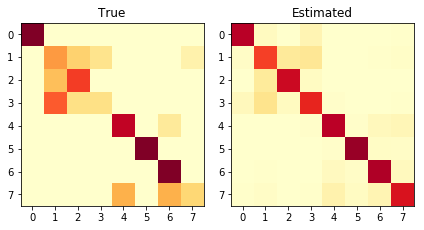

JS divergence: 0.1103	Norm Frobenius: 0.1325


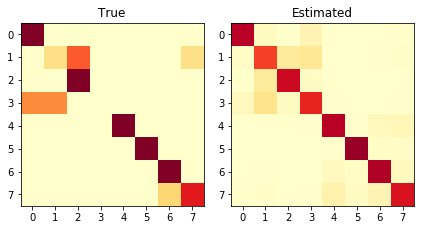

JS divergence: 0.1729	Norm Frobenius: 0.1515


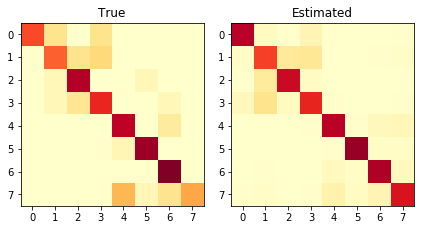

JS divergence: 0.0695	Norm Frobenius: 0.0800


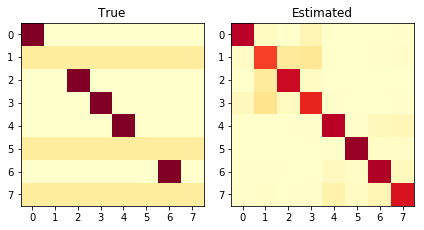

JS divergence: 0.2282	Norm Frobenius: 0.1701


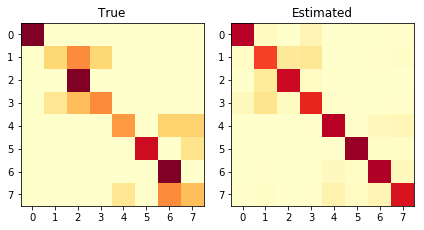

JS divergence: 0.1273	Norm Frobenius: 0.1396
Calculate confusion matrix on global version


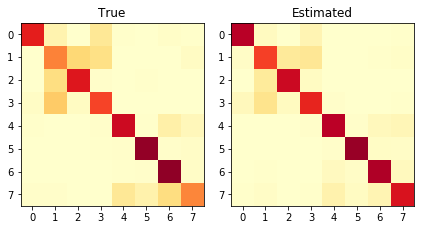

JS divergence: 0.0242	Norm Frobenius: 0.0566
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.826       0.826        0.172003     0.216288     0.121733   

   (R) JS w  (G) NormF    (G) JS  
0  0.122006   0.056558  0.024225

Test
A result


Accuracy  F1 (micro)
0  All  0.794613    0.794613

In [18]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


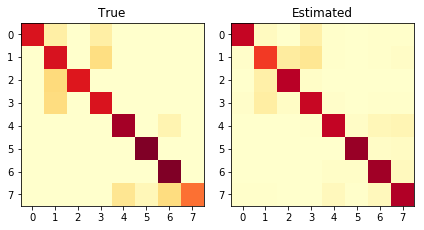

JS divergence: 0.0510	Norm Frobenius: 0.0650


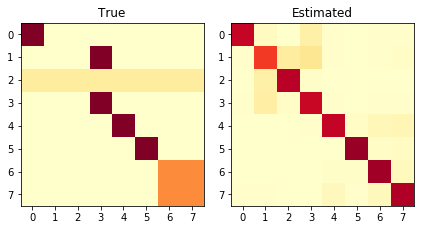

JS divergence: 0.2464	Norm Frobenius: 0.2055


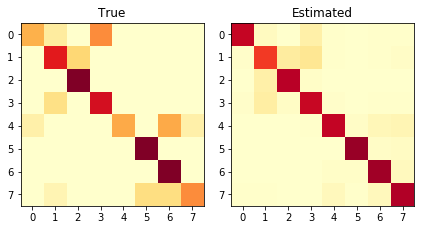

JS divergence: 0.1153	Norm Frobenius: 0.1279


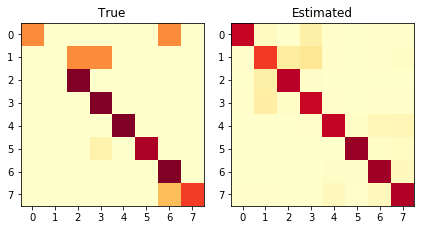

JS divergence: 0.1641	Norm Frobenius: 0.1445


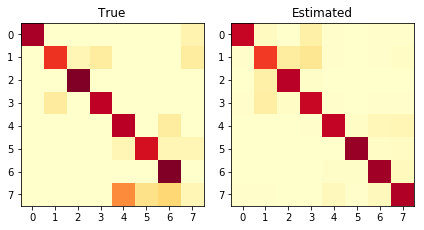

JS divergence: 0.1245	Norm Frobenius: 0.1305


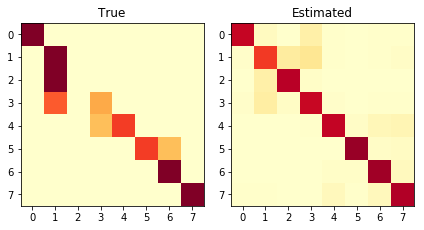

JS divergence: 0.2129	Norm Frobenius: 0.1991


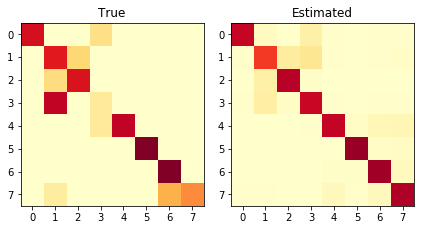

JS divergence: 0.1306	Norm Frobenius: 0.1499


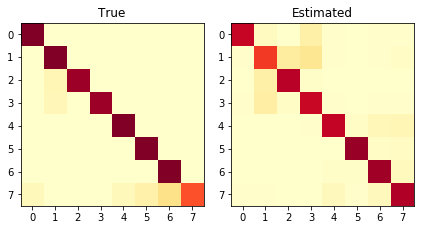

JS divergence: 0.0697	Norm Frobenius: 0.0743


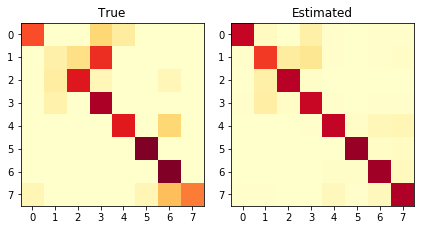

JS divergence: 0.1062	Norm Frobenius: 0.1262


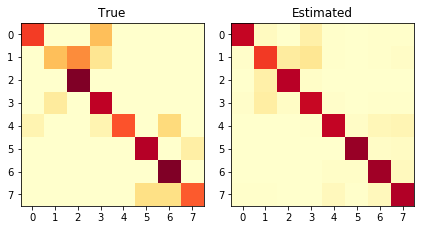

JS divergence: 0.0894	Norm Frobenius: 0.1000


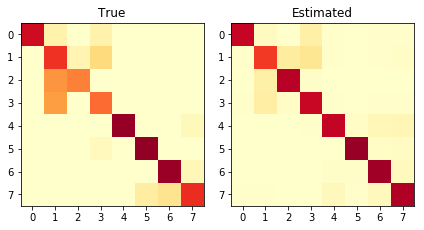

JS divergence: 0.0635	Norm Frobenius: 0.0917


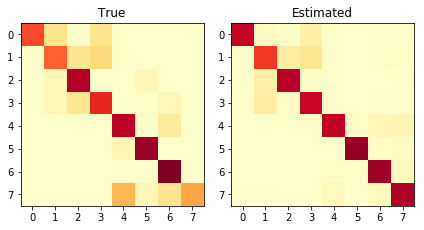

JS divergence: 0.0726	Norm Frobenius: 0.0888


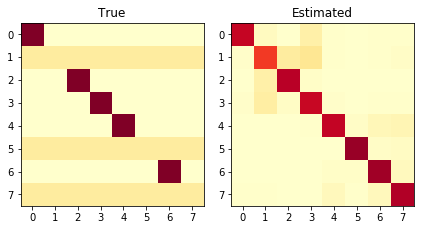

JS divergence: 0.2350	Norm Frobenius: 0.1752


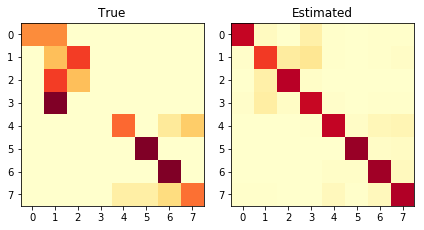

JS divergence: 0.2305	Norm Frobenius: 0.2232


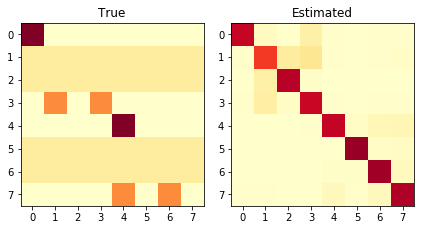

JS divergence: 0.4050	Norm Frobenius: 0.2530
Calculate confusion matrix on global version


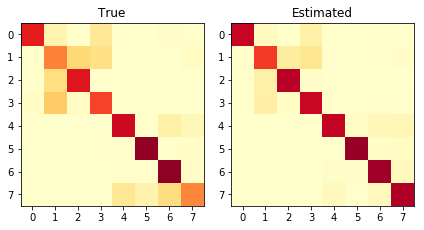

JS divergence: 0.0347	Norm Frobenius: 0.0736
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.804       0.804        0.181207     0.225159     0.130604   

   (R) JS w  (G) NormF    (G) JS  
0   0.12677   0.073609  0.034694

Test
A result


Accuracy  F1 (micro)
0  All   0.79798     0.79798

In [20]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


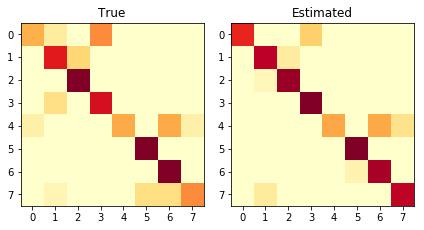

JS divergence: 0.0799	Norm Frobenius: 0.0938


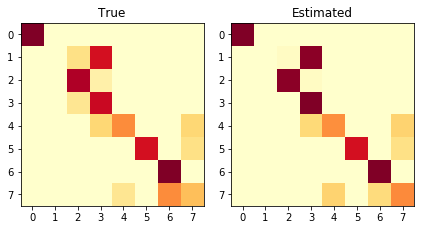

JS divergence: 0.0285	Norm Frobenius: 0.0615


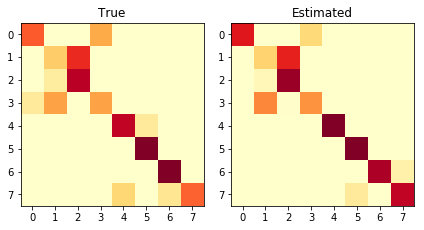

JS divergence: 0.0667	Norm Frobenius: 0.0725


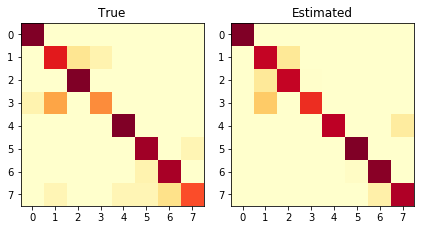

JS divergence: 0.0518	Norm Frobenius: 0.0645


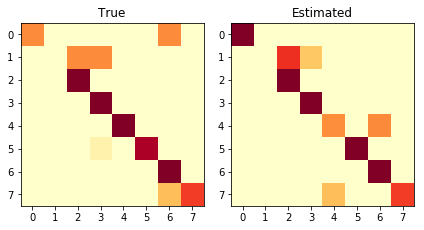

JS divergence: 0.1301	Norm Frobenius: 0.1441


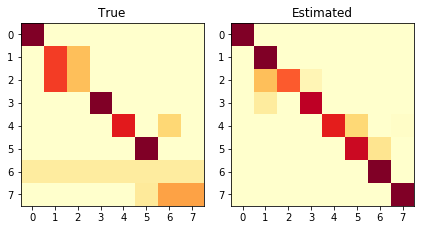

JS divergence: 0.2246	Norm Frobenius: 0.1782


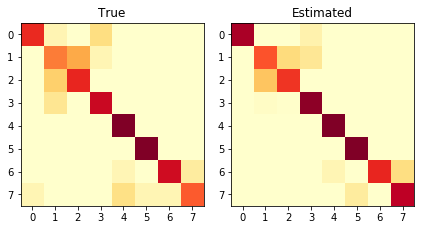

JS divergence: 0.0438	Norm Frobenius: 0.0671


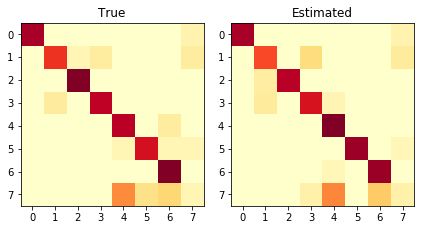

JS divergence: 0.0568	Norm Frobenius: 0.0516


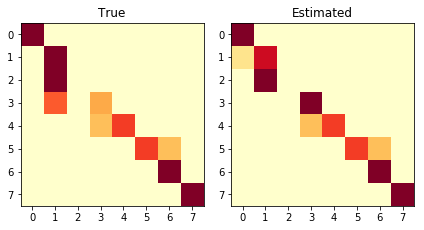

JS divergence: 0.0618	Norm Frobenius: 0.1109


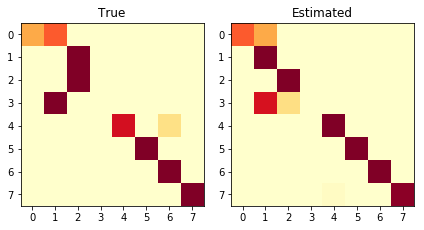

JS divergence: 0.1578	Norm Frobenius: 0.1873


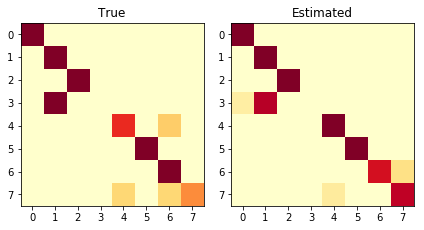

JS divergence: 0.0627	Norm Frobenius: 0.0865


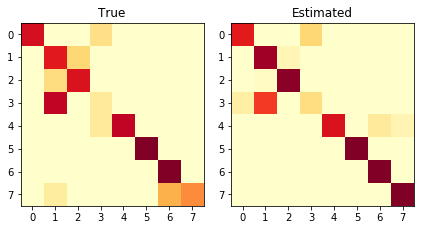

JS divergence: 0.0858	Norm Frobenius: 0.1016


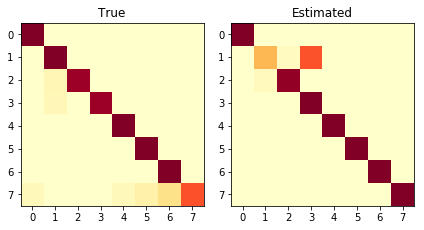

JS divergence: 0.0871	Norm Frobenius: 0.1252


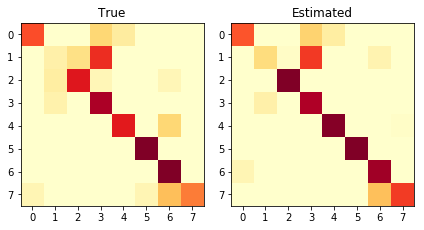

JS divergence: 0.0628	Norm Frobenius: 0.0672


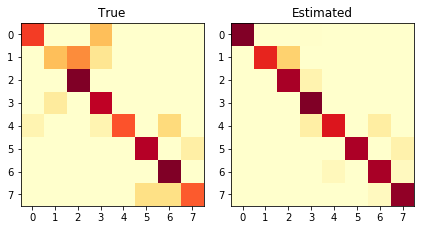

JS divergence: 0.0912	Norm Frobenius: 0.1086
Calculate confusion matrix on global version


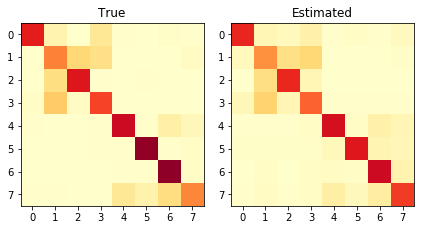

JS divergence: 0.0357	Norm Frobenius: 0.0468
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.864       0.864        0.139434      0.15302     0.098342   

   (R) JS w  (G) NormF   (G) JS  
0  0.085778   0.046829  0.03573

Test
A result


Accuracy  F1 (micro)
0  All  0.835859    0.835859

In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


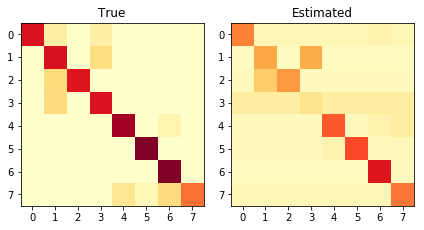

JS divergence: 0.2167	Norm Frobenius: 0.1388


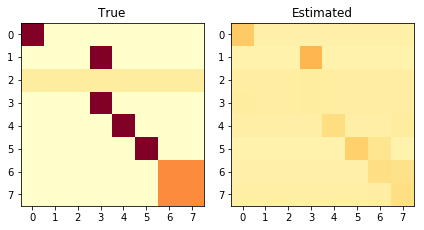

JS divergence: 0.4517	Norm Frobenius: 0.2420


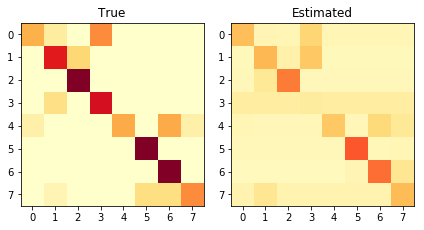

JS divergence: 0.2862	Norm Frobenius: 0.1646


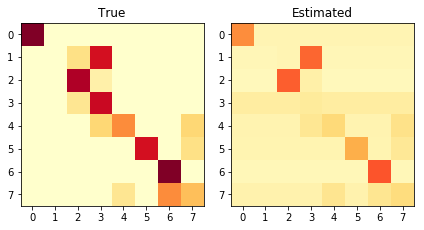

JS divergence: 0.2891	Norm Frobenius: 0.1635


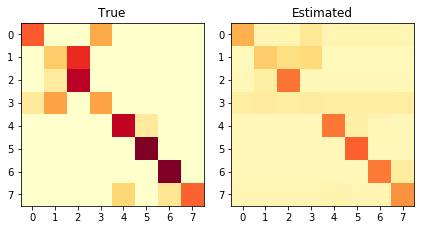

JS divergence: 0.2775	Norm Frobenius: 0.1520


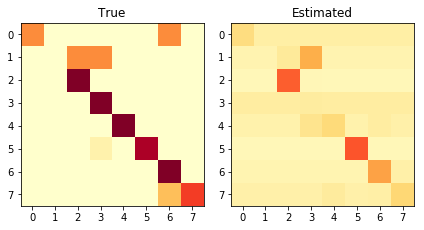

JS divergence: 0.4123	Norm Frobenius: 0.2159


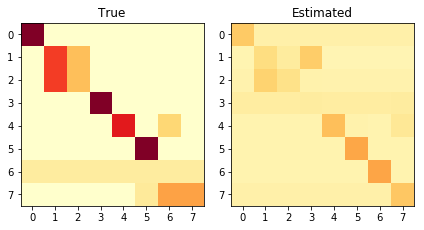

JS divergence: 0.3981	Norm Frobenius: 0.2144


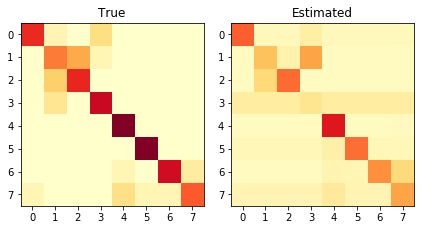

JS divergence: 0.2142	Norm Frobenius: 0.1443


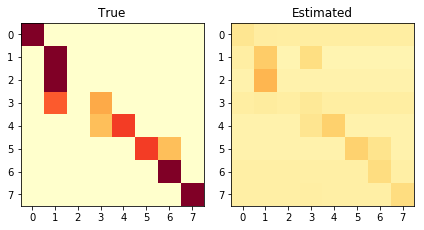

JS divergence: 0.4964	Norm Frobenius: 0.2515


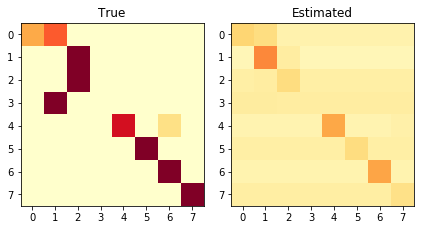

JS divergence: 0.5326	Norm Frobenius: 0.2757


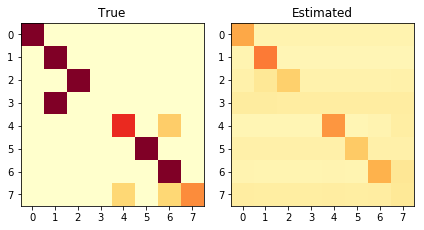

JS divergence: 0.4382	Norm Frobenius: 0.2335


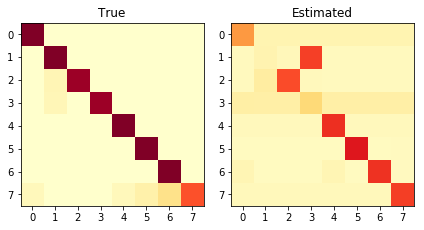

JS divergence: 0.2959	Norm Frobenius: 0.2018


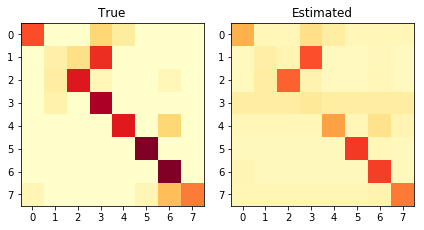

JS divergence: 0.2205	Norm Frobenius: 0.1416


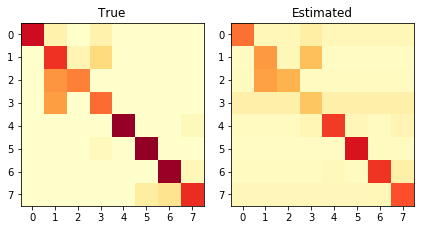

JS divergence: 0.1647	Norm Frobenius: 0.1021


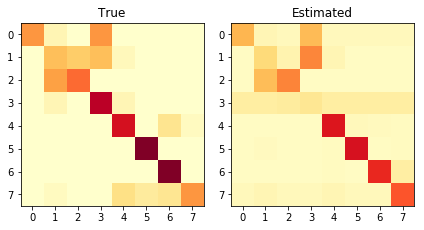

JS divergence: 0.1693	Norm Frobenius: 0.1229
Calculate confusion matrix on global version


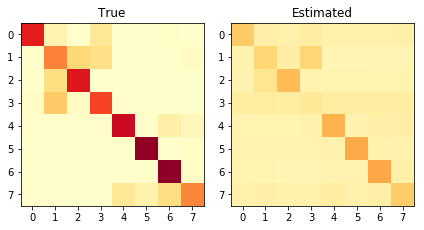

JS divergence: 0.2774	Norm Frobenius: 0.1762
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.746       0.746        0.189759     0.319859     0.164402   

   (R) JS w  (G) NormF   (G) JS  RMSE mean    RMSE w  
0  0.274857   0.176225  0.27739     0.0681  0.050255

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                 0.80951             1.16896                 0.783274   

   Cross entropy wmean  
0              0.95573

Test
A result


Accuracy  F1 (micro)
0  All  0.736532    0.736532

In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


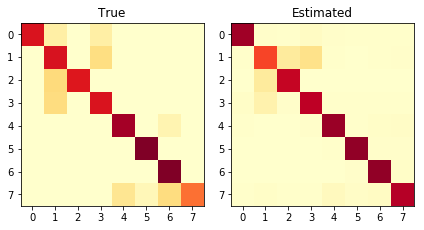

JS divergence: 0.0566	Norm Frobenius: 0.0679
Groups probabilities:  [1. 0. 0.]


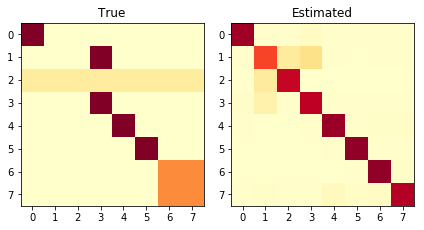

JS divergence: 0.2320	Norm Frobenius: 0.2000
Groups probabilities:  [1. 0. 0.]


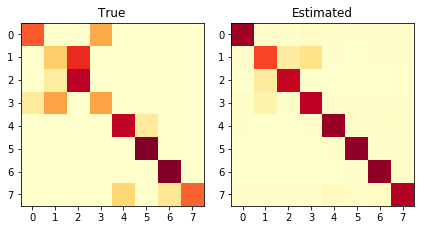

JS divergence: 0.1248	Norm Frobenius: 0.1409
Groups probabilities:  [1. 0. 0.]


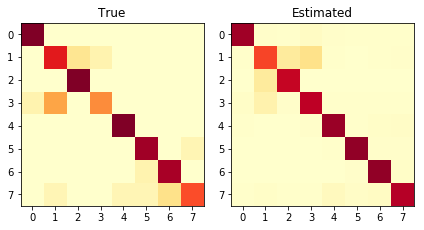

JS divergence: 0.0625	Norm Frobenius: 0.0827
Groups probabilities:  [1. 0. 0.]


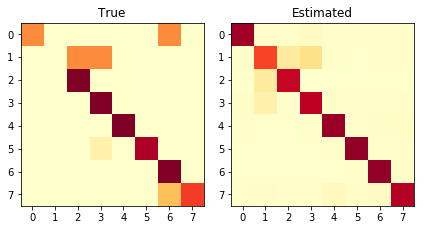

JS divergence: 0.1501	Norm Frobenius: 0.1430
Groups probabilities:  [1. 0. 0.]


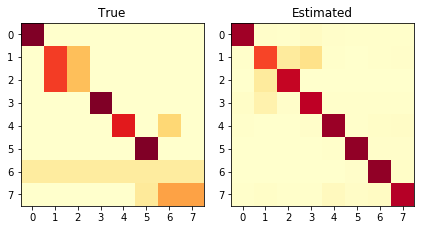

JS divergence: 0.1902	Norm Frobenius: 0.1739
Groups probabilities:  [1. 0. 0.]


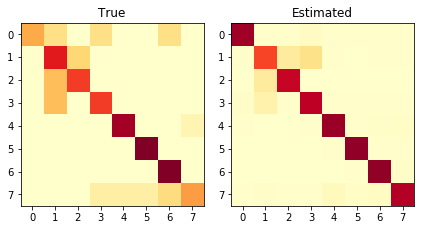

JS divergence: 0.1062	Norm Frobenius: 0.1177
Groups probabilities:  [1. 0. 0.]


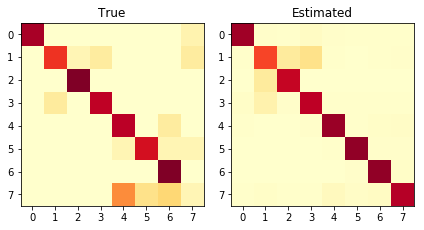

JS divergence: 0.1259	Norm Frobenius: 0.1313
Groups probabilities:  [1. 0. 0.]


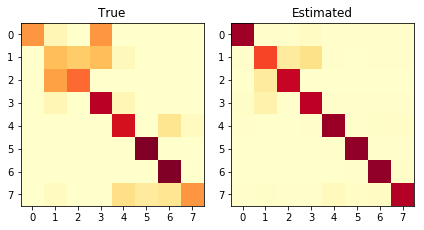

JS divergence: 0.0985	Norm Frobenius: 0.1260
Groups probabilities:  [1. 0. 0.]


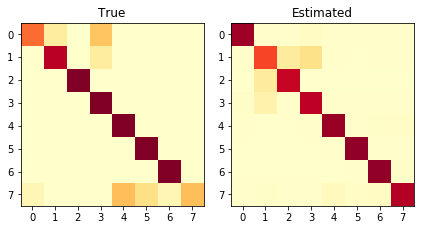

JS divergence: 0.1010	Norm Frobenius: 0.1127
Groups probabilities:  [1. 0. 0.]


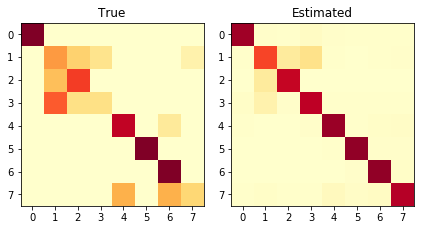

JS divergence: 0.1338	Norm Frobenius: 0.1559
Groups probabilities:  [1. 0. 0.]


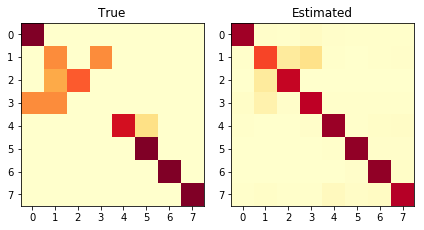

JS divergence: 0.1548	Norm Frobenius: 0.1537
Groups probabilities:  [1. 0. 0.]


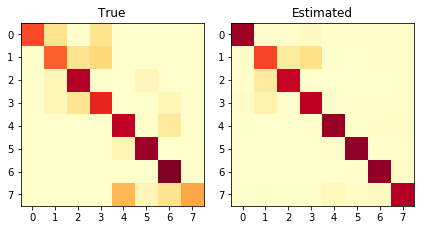

JS divergence: 0.0836	Norm Frobenius: 0.0956
Groups probabilities:  [1. 0. 0.]


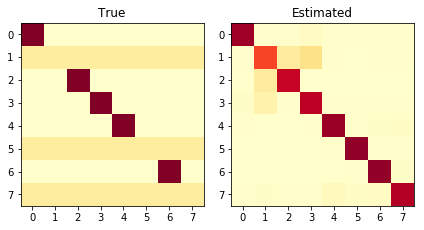

JS divergence: 0.2172	Norm Frobenius: 0.1722
Groups probabilities:  [1. 0. 0.]


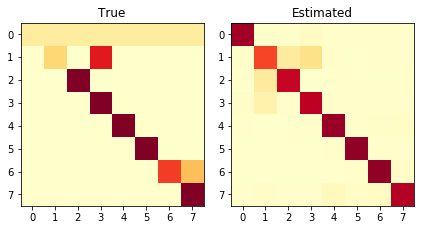

JS divergence: 0.1555	Norm Frobenius: 0.1535
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


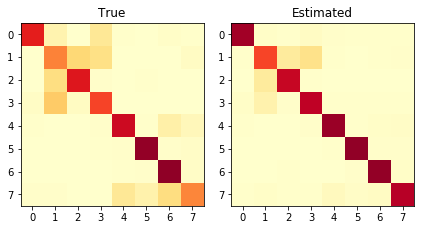

JS divergence: 0.0473	Norm Frobenius: 0.0795
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.853       0.853           0.185       0.2281       0.1343   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1317     0.0795  0.0473     0.1734  0.1296

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7515              0.6746                   0.7888   

   Cross entropy wmean  
0                0.617

Test


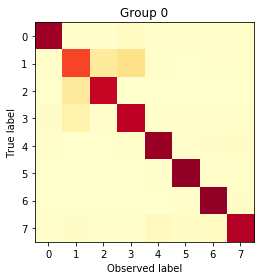

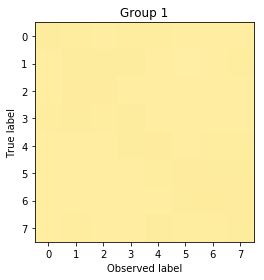

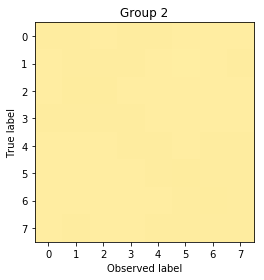

Inertia JS: 0.3501555499831124
Inertia NormF: 0.1925510933312277
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.9972    58   0.4696     0.8809     0.9069    0.8639  0.0125   
1       1  0.0018     0   2.0785     0.1330    -0.0162    0.0091  0.0017   
2       2  0.0010     0   2.0793     0.1284    -0.0265    0.0039  0.0008   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       3   0.3502      0.1926    0.8359      0.8359  
1       7   0.3502      0.1926    0.6254      0.6254  
2       7   0.3502      0.1926    0.6136      0.6136

A result


Accuracy  F1 (micro)
0  All    0.8266      0.8266

In [20]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


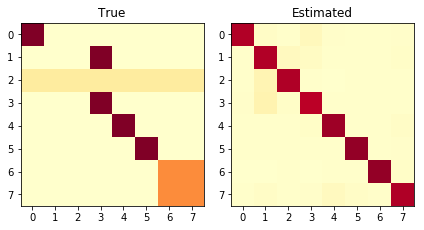

JS divergence: 0.2762	Norm Frobenius: 0.2281
Groups probabilities:  [0.9428 0.0572]


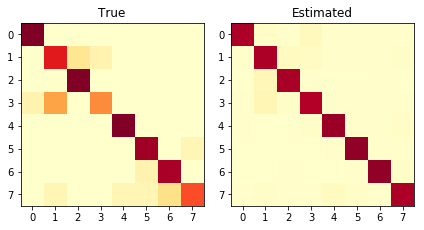

JS divergence: 0.0716	Norm Frobenius: 0.0869
Groups probabilities:  [9.993e-01 7.000e-04]


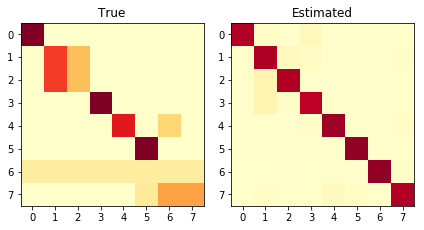

JS divergence: 0.2069	Norm Frobenius: 0.1832
Groups probabilities:  [0.9365 0.0635]


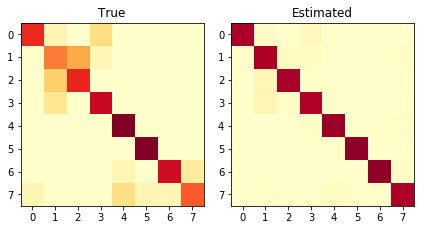

JS divergence: 0.0821	Norm Frobenius: 0.0988
Groups probabilities:  [9.996e-01 4.000e-04]


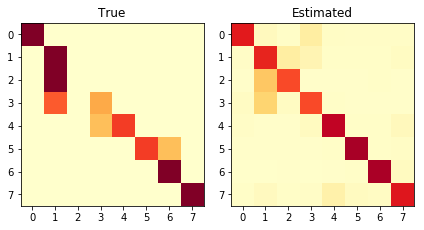

JS divergence: 0.1767	Norm Frobenius: 0.1582
Groups probabilities:  [0.1331 0.8669]


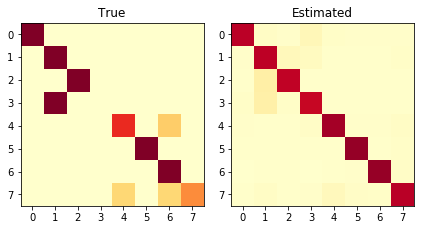

JS divergence: 0.1731	Norm Frobenius: 0.1747
Groups probabilities:  [0.83 0.17]


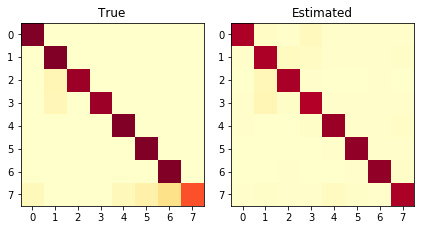

JS divergence: 0.0425	Norm Frobenius: 0.0495
Groups probabilities:  [1. 0.]


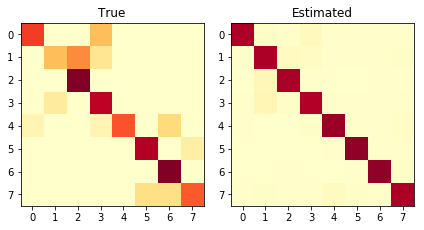

JS divergence: 0.1245	Norm Frobenius: 0.1299
Groups probabilities:  [1. 0.]


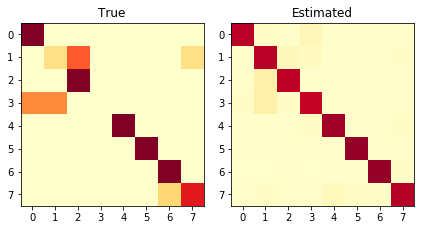

JS divergence: 0.1993	Norm Frobenius: 0.1795
Groups probabilities:  [0.8648 0.1352]


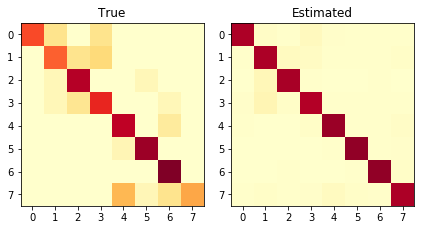

JS divergence: 0.1017	Norm Frobenius: 0.1086
Groups probabilities:  [1. 0.]


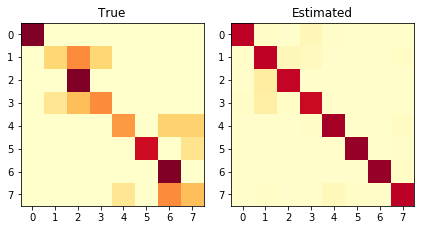

JS divergence: 0.1810	Norm Frobenius: 0.1694
Groups probabilities:  [0.7899 0.2101]


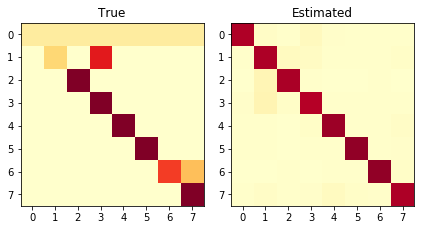

JS divergence: 0.1709	Norm Frobenius: 0.1715
Groups probabilities:  [0.9815 0.0185]


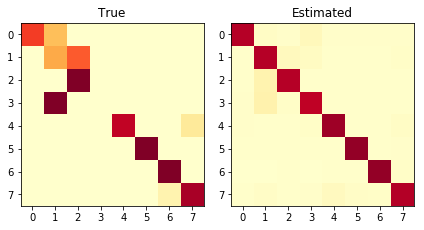

JS divergence: 0.1880	Norm Frobenius: 0.1913
Groups probabilities:  [0.9136 0.0864]


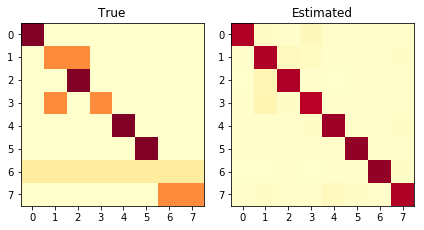

JS divergence: 0.1868	Norm Frobenius: 0.1737
Groups probabilities:  [0.9569 0.0431]


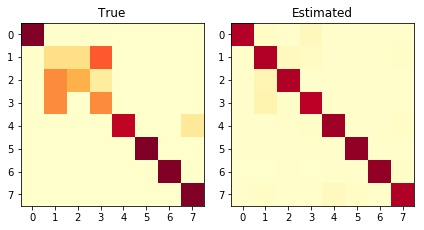

JS divergence: 0.1408	Norm Frobenius: 0.1618
Groups probabilities:  [0.9401 0.0599]
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.843       0.843           0.188       0.2326       0.1421   

   (R) JS w  RMSE mean  RMSE w  
0    0.1441     0.1456  0.1052

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7979              0.5589                   0.8214   

   Cross entropy wmean  
0               0.5187

Test


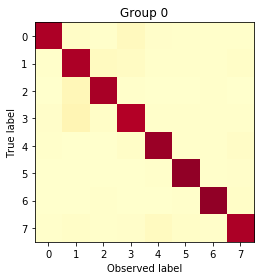

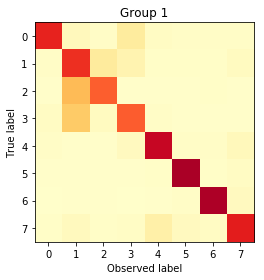

Inertia JS: 0.046423794238964984
Inertia NormF: 0.08692646026611328
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.6998    41   0.3795     0.9251     0.9443    0.9144  0.0096   
1       1  0.3002    17   0.8516     0.7517     0.7971    0.7162  0.0601   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.0464      0.0869    0.8325      0.8325  
1       1   0.0464      0.0869    0.8199      0.8199

A result


Accuracy  F1 (micro)
0  All    0.8333      0.8333

In [27]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual2 multiples runs***
Train
Calculate confusion matrix on repeat version


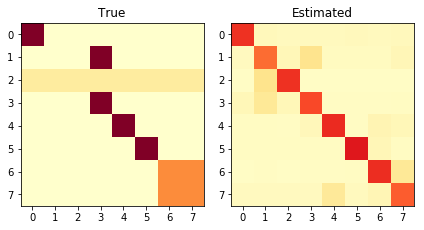

JS divergence: 0.2663	Norm Frobenius: 0.1867
Groups probabilities:  [1. 0. 0.]


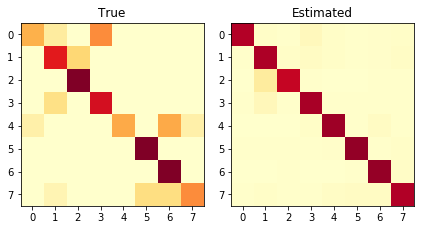

JS divergence: 0.1418	Norm Frobenius: 0.1441
Groups probabilities:  [0. 1. 0.]


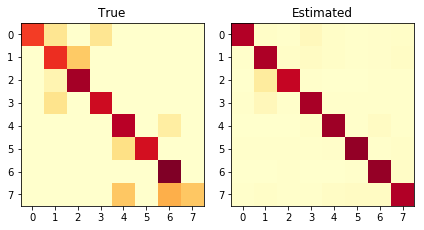

JS divergence: 0.1132	Norm Frobenius: 0.1176
Groups probabilities:  [0. 1. 0.]


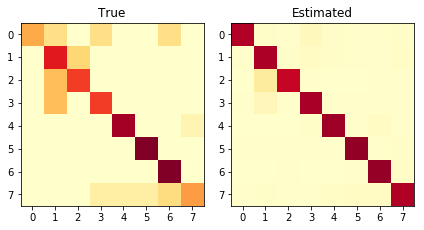

JS divergence: 0.1129	Norm Frobenius: 0.1194
Groups probabilities:  [0. 1. 0.]


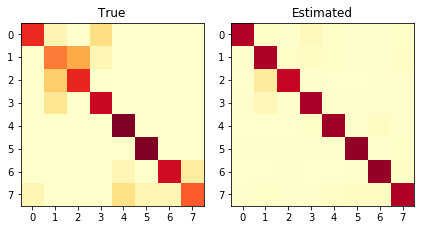

JS divergence: 0.0820	Norm Frobenius: 0.0951
Groups probabilities:  [0. 1. 0.]


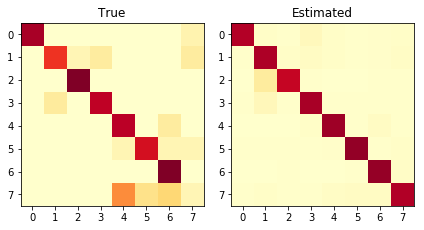

JS divergence: 0.1342	Norm Frobenius: 0.1359
Groups probabilities:  [0. 1. 0.]


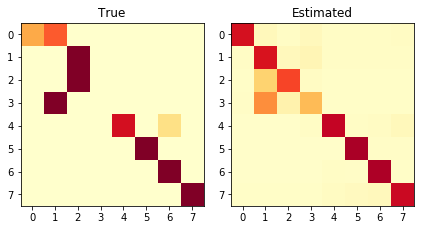

JS divergence: 0.2525	Norm Frobenius: 0.2041
Groups probabilities:  [0. 0. 1.]


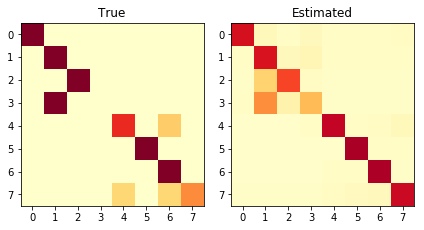

JS divergence: 0.1513	Norm Frobenius: 0.1250
Groups probabilities:  [0. 0. 1.]


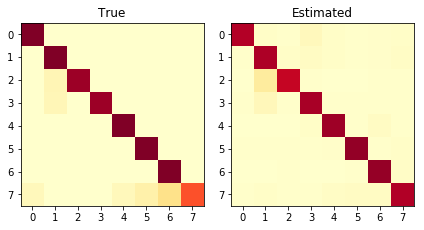

JS divergence: 0.0423	Norm Frobenius: 0.0501
Groups probabilities:  [0. 1. 0.]


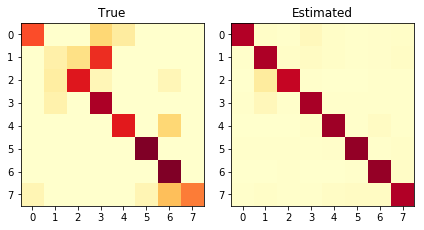

JS divergence: 0.1498	Norm Frobenius: 0.1580
Groups probabilities:  [0. 1. 0.]


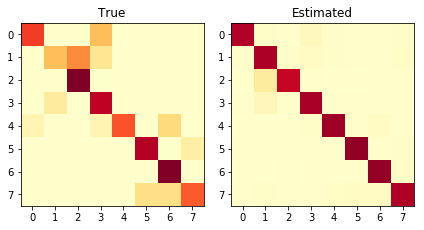

JS divergence: 0.1260	Norm Frobenius: 0.1305
Groups probabilities:  [0. 1. 0.]


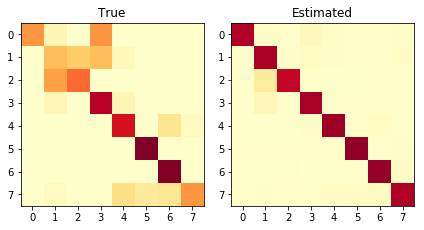

JS divergence: 0.1276	Norm Frobenius: 0.1440
Groups probabilities:  [0. 1. 0.]


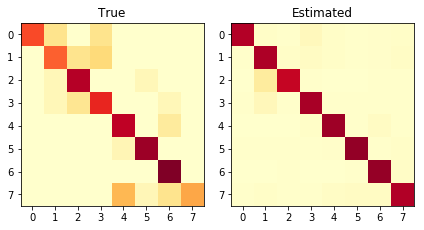

JS divergence: 0.1048	Norm Frobenius: 0.1084
Groups probabilities:  [0. 1. 0.]


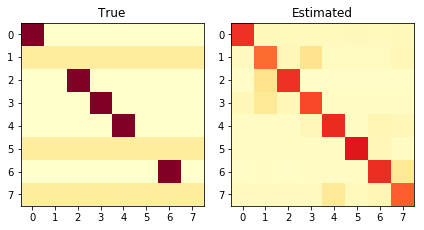

JS divergence: 0.2046	Norm Frobenius: 0.1568
Groups probabilities:  [1. 0. 0.]


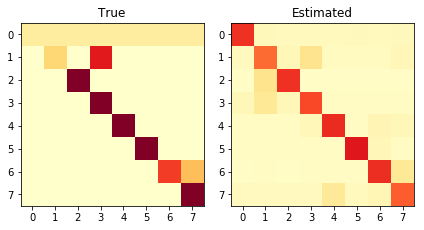

JS divergence: 0.1991	Norm Frobenius: 0.1533
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


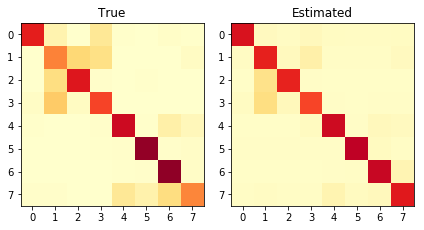

JS divergence: 0.0580	Norm Frobenius: 0.0641
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.841       0.841          0.1666       0.2092       0.1333   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1412     0.0641   0.058     0.1219  0.0864

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7985              0.6445                   0.8237   

   Cross entropy wmean  
0               0.5383

Test


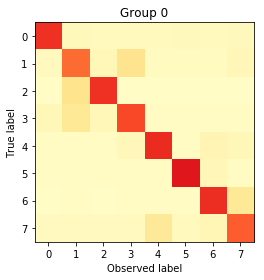

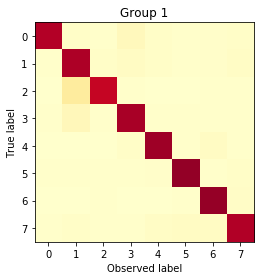

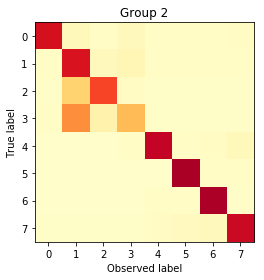

Inertia JS: 0.059319047974818954
Inertia NormF: 0.09458952469786618
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.4068    23   1.2007     0.6687     0.8093    0.6214  0.0082   
1       1  0.3220    19   0.4175     0.9126     0.9546    0.9001  0.0145   
2       2  0.2712    16   0.8119     0.7573     0.8562    0.7227  0.0816   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.0593      0.0946    0.8173      0.8173  
1       1   0.0593      0.0946    0.8207      0.8207  
2       1   0.0593      0.0946    0.7483      0.7483

A result


Accuracy  F1 (micro)
0  All    0.8215      0.8215

In [18]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individua3l multiples runs***
Train
Calculate confusion matrix on repeat version


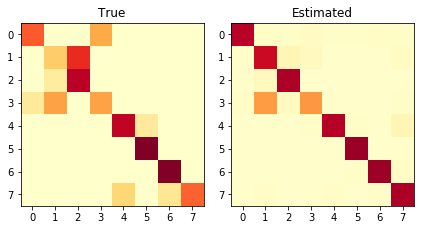

JS divergence: 0.1321	Norm Frobenius: 0.1359
Groups probabilities:  [0.     0.2727 0.7273]


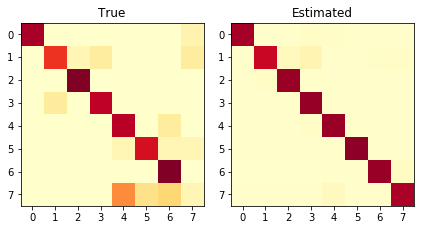

JS divergence: 0.1339	Norm Frobenius: 0.1342
Groups probabilities:  [0.000e+00 9.992e-01 8.000e-04]


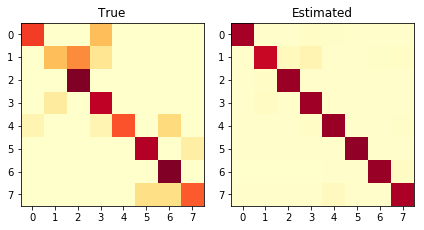

JS divergence: 0.1242	Norm Frobenius: 0.1257
Groups probabilities:  [0.     0.9768 0.0232]


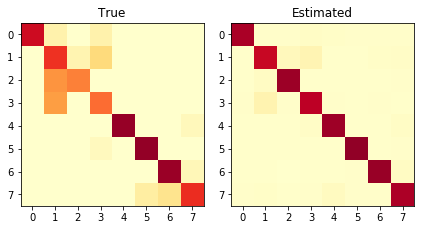

JS divergence: 0.0929	Norm Frobenius: 0.1085
Groups probabilities:  [0.     0.8841 0.1159]


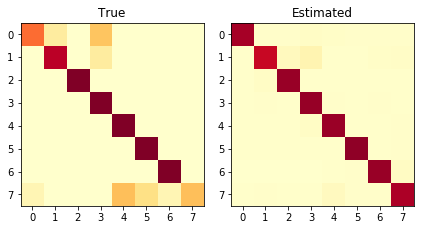

JS divergence: 0.0880	Norm Frobenius: 0.1053
Groups probabilities:  [0. 1. 0.]


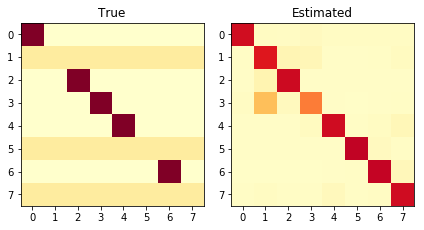

JS divergence: 0.2285	Norm Frobenius: 0.1813
Groups probabilities:  [0.1275 0.3947 0.4779]


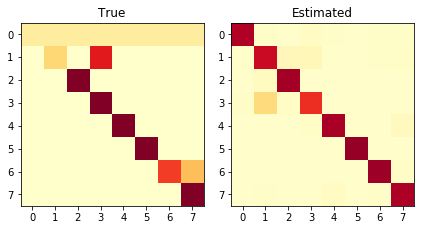

JS divergence: 0.1754	Norm Frobenius: 0.1700
Groups probabilities:  [0.0052 0.6296 0.3652]


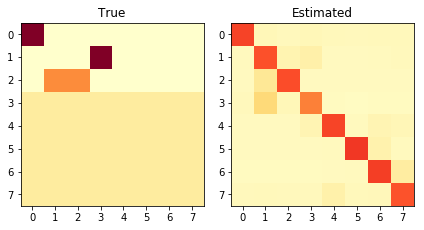

JS divergence: 0.2885	Norm Frobenius: 0.2160
Groups probabilities:  [0.3908 0.4106 0.1986]


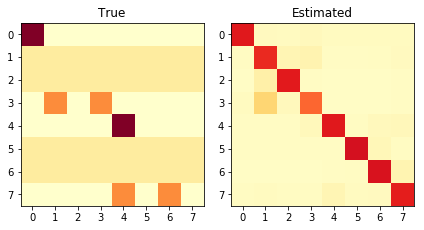

JS divergence: 0.3122	Norm Frobenius: 0.2173
Groups probabilities:  [0.224  0.4649 0.3111]


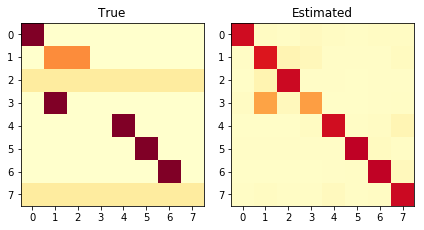

JS divergence: 0.2203	Norm Frobenius: 0.1787
Groups probabilities:  [0.1117 0.2523 0.636 ]


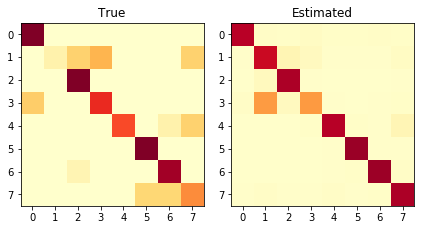

JS divergence: 0.1838	Norm Frobenius: 0.1547
Groups probabilities:  [0.    0.264 0.736]


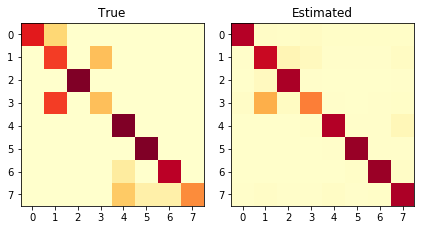

JS divergence: 0.1017	Norm Frobenius: 0.0984
Groups probabilities:  [1.000e-04 3.736e-01 6.263e-01]


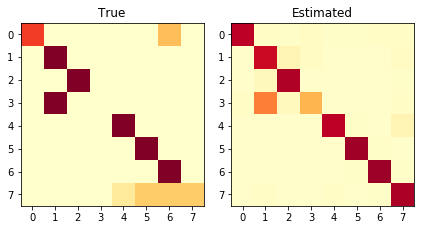

JS divergence: 0.1457	Norm Frobenius: 0.1332
Groups probabilities:  [0.0029 0.1298 0.8672]


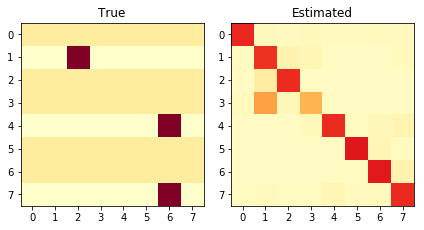

JS divergence: 0.5004	Norm Frobenius: 0.3086
Groups probabilities:  [0.2616 0.1575 0.5809]


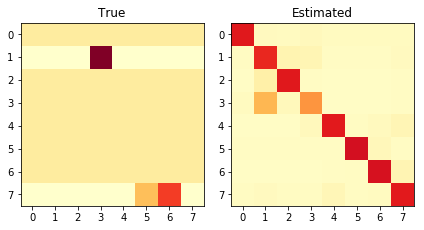

JS divergence: 0.4536	Norm Frobenius: 0.2816
Groups probabilities:  [0.2111 0.3087 0.4802]
Calculate confusion matrix on global version


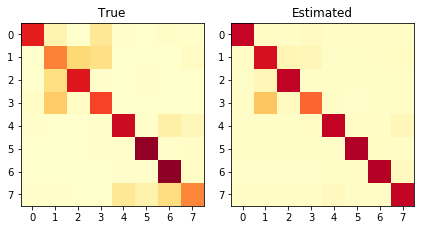

JS divergence: 0.0648	Norm Frobenius: 0.0780
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All      0.83        0.83          0.1687       0.2061       0.1311   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0     0.138      0.078  0.0648     0.1174  0.0797

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.8019              0.6363                   0.8257   

   Cross entropy wmean  
0               0.5429

Test


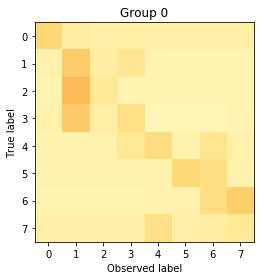

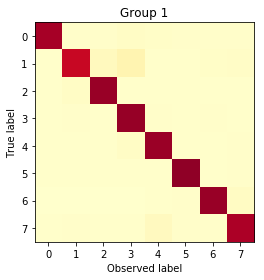

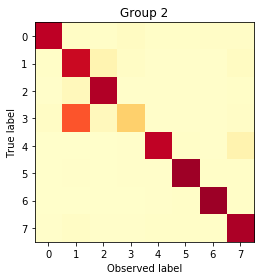

Inertia JS: 0.2832880696002876
Inertia NormF: 0.21139562971169265
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.0769     4   1.9686     0.2186     0.4110    0.1069  0.0572   
1       1  0.4593    27   0.3742     0.9275     0.9624    0.9171  0.0108   
2       2  0.4638    27   0.5923     0.8146     0.8856    0.7881  0.0665   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.2833      0.2114    0.4276      0.4276  
1       3   0.2833      0.2114    0.8072      0.8072  
2       1   0.2833      0.2114    0.7348      0.7348

A result


Accuracy  F1 (micro)
0  All    0.8056      0.8056

In [21]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individua3l multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [27]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

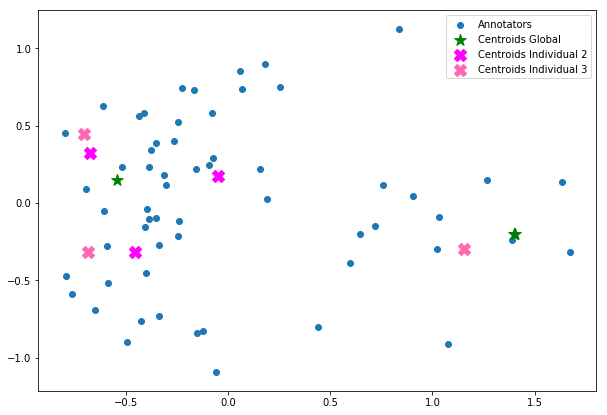

In [28]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()

In [ ]:
### e individual con 2 grupos??

*** Ours Individual2 multiples runs***
Train
Calculate confusion matrix on repeat version


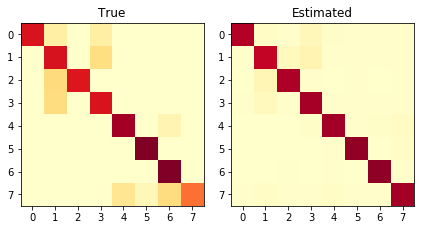

JS divergence: 0.0658	Norm Frobenius: 0.0752
Groups probabilities:  [0. 1.]


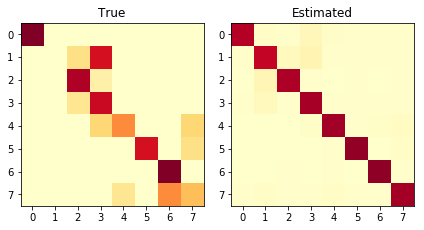

JS divergence: 0.2128	Norm Frobenius: 0.1897
Groups probabilities:  [0. 1.]


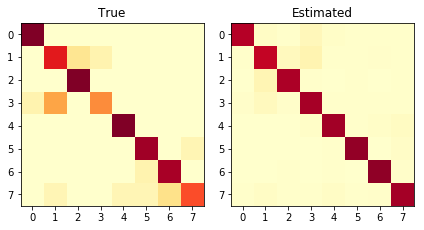

JS divergence: 0.0768	Norm Frobenius: 0.0907
Groups probabilities:  [0. 1.]


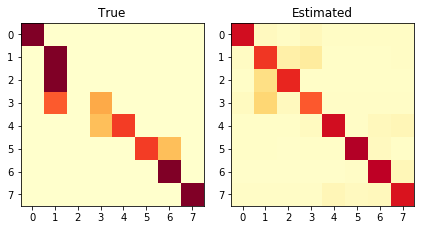

JS divergence: 0.1936	Norm Frobenius: 0.1687
Groups probabilities:  [1. 0.]


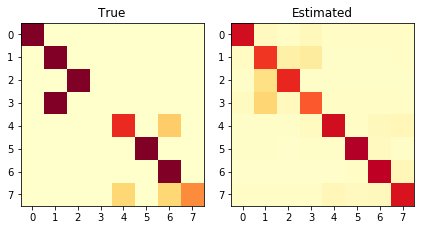

JS divergence: 0.1789	Norm Frobenius: 0.1523
Groups probabilities:  [1. 0.]


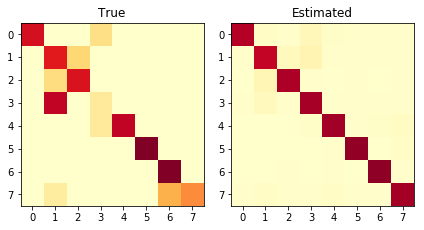

JS divergence: 0.1466	Norm Frobenius: 0.1654
Groups probabilities:  [0. 1.]


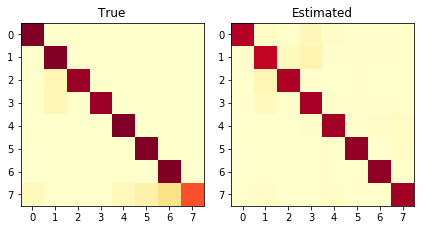

JS divergence: 0.0506	Norm Frobenius: 0.0548
Groups probabilities:  [0. 1.]


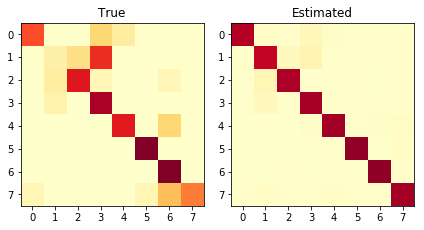

JS divergence: 0.1425	Norm Frobenius: 0.1529
Groups probabilities:  [0. 1.]


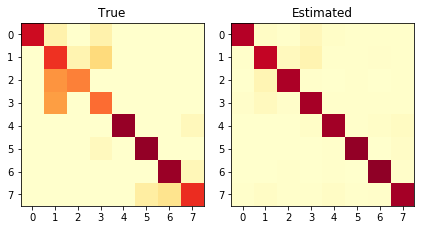

JS divergence: 0.0858	Norm Frobenius: 0.1085
Groups probabilities:  [0. 1.]


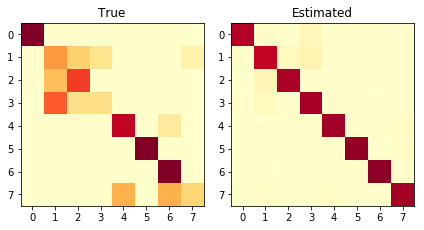

JS divergence: 0.1743	Norm Frobenius: 0.1761
Groups probabilities:  [0. 1.]


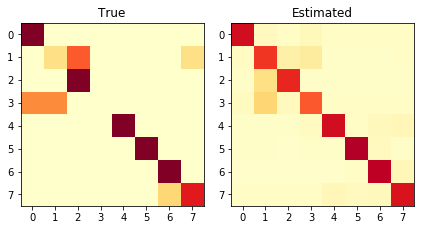

JS divergence: 0.1989	Norm Frobenius: 0.1516
Groups probabilities:  [1. 0.]


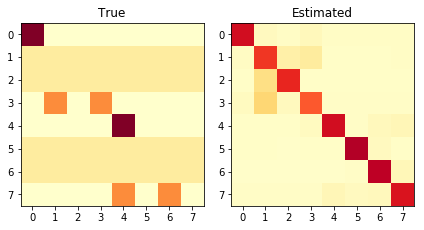

JS divergence: 0.3433	Norm Frobenius: 0.2267
Groups probabilities:  [1. 0.]


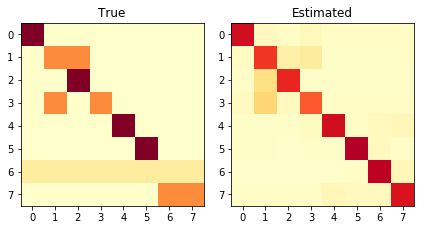

JS divergence: 0.1847	Norm Frobenius: 0.1496
Groups probabilities:  [1. 0.]


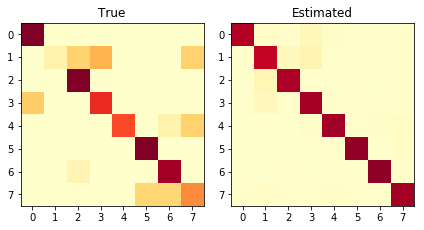

JS divergence: 0.1605	Norm Frobenius: 0.1478
Groups probabilities:  [0. 1.]


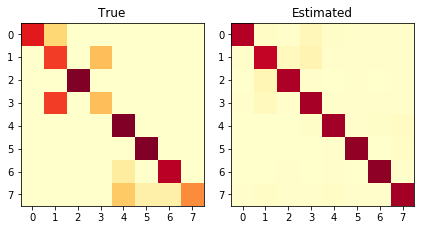

JS divergence: 0.1270	Norm Frobenius: 0.1390
Groups probabilities:  [0. 1.]
Calculate confusion matrix on global version


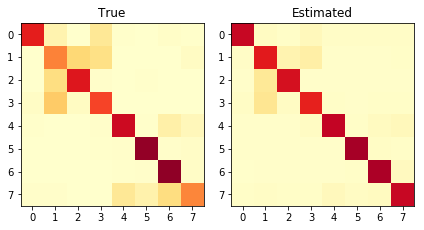

JS divergence: 0.0466	Norm Frobenius: 0.0699
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.852       0.852          0.1776       0.2199       0.1393   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1431     0.0699  0.0466     0.1469  0.1076

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.7915              0.6186                   0.8233   

   Cross entropy wmean  
0               0.5339

Test


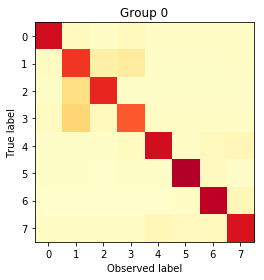

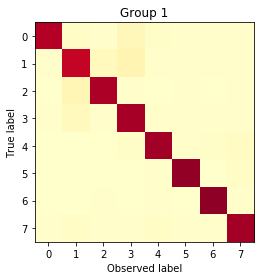

Inertia JS: 0.03860391413997662
Inertia NormF: 0.06940804228463358
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.5932    34   0.8650     0.7700     0.8720    0.7372  0.0334   
1       1  0.4068    24   0.3981     0.9182     0.9576    0.9065  0.0102   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.0386      0.0694    0.8283      0.8283  
1       3   0.0386      0.0694    0.8274      0.8274

A result


Accuracy  F1 (micro)
0  All    0.8266      0.8266

In [25]:
evaluate = Evaluation_metrics(gMixture_Ind2,'our1') 
aux = gMixture_Ind2.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind2.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual2 multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind2.get_confusionM()
y_o_groups = gMixture_Ind2.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individua3l multiples runs***
Train
Calculate confusion matrix on repeat version


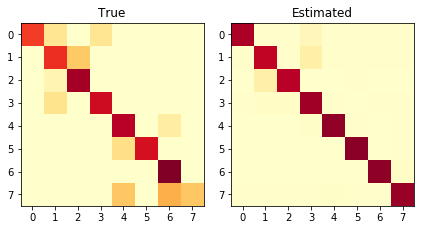

JS divergence: 0.1289	Norm Frobenius: 0.1241
Groups probabilities:  [0. 1.]


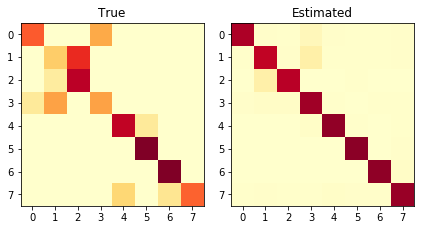

JS divergence: 0.1608	Norm Frobenius: 0.1647
Groups probabilities:  [0. 1.]


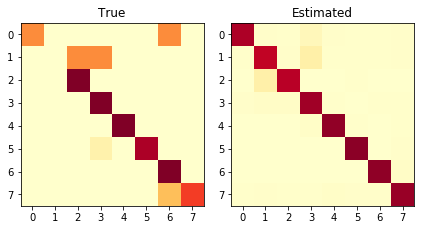

JS divergence: 0.1811	Norm Frobenius: 0.1664
Groups probabilities:  [0. 1.]


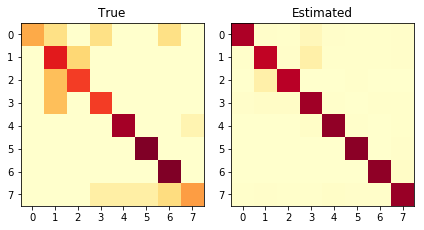

JS divergence: 0.1299	Norm Frobenius: 0.1276
Groups probabilities:  [0. 1.]


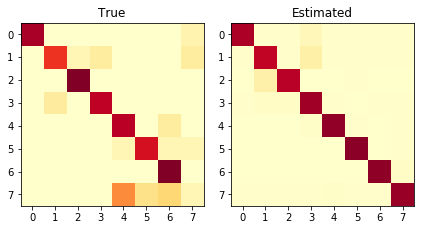

JS divergence: 0.1470	Norm Frobenius: 0.1411
Groups probabilities:  [0. 1.]


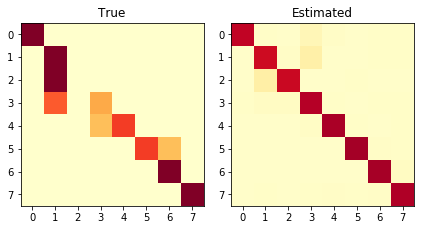

JS divergence: 0.2111	Norm Frobenius: 0.1966
Groups probabilities:  [0.0586 0.9414]


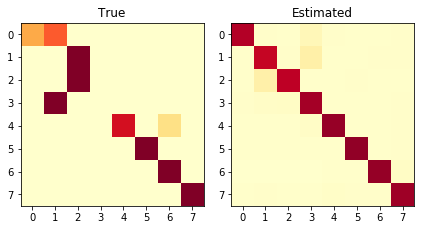

JS divergence: 0.3166	Norm Frobenius: 0.2567
Groups probabilities:  [0.0138 0.9862]


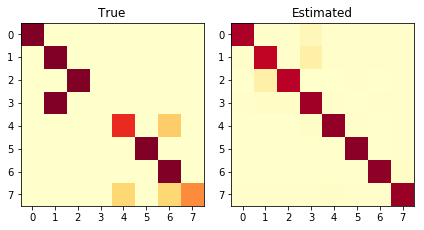

JS divergence: 0.1979	Norm Frobenius: 0.1922
Groups probabilities:  [6.000e-04 9.994e-01]


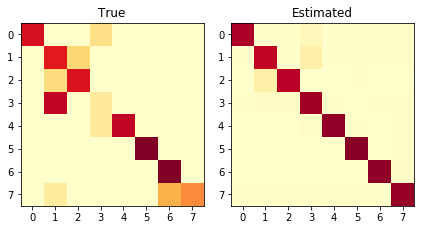

JS divergence: 0.1567	Norm Frobenius: 0.1700
Groups probabilities:  [0. 1.]


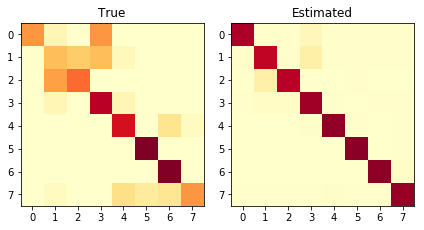

JS divergence: 0.1321	Norm Frobenius: 0.1456
Groups probabilities:  [0. 1.]


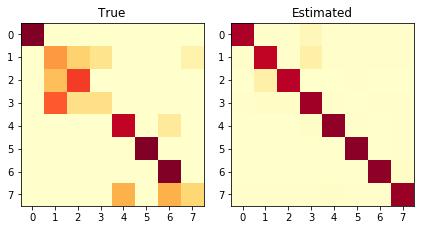

JS divergence: 0.1797	Norm Frobenius: 0.1791
Groups probabilities:  [0. 1.]


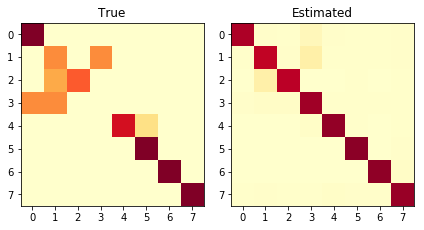

JS divergence: 0.1733	Norm Frobenius: 0.1714
Groups probabilities:  [0.0012 0.9988]


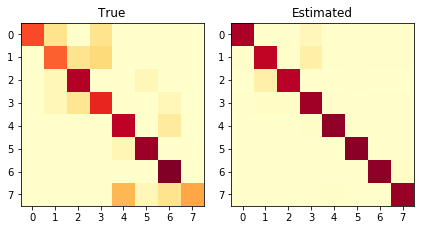

JS divergence: 0.1020	Norm Frobenius: 0.1102
Groups probabilities:  [0. 1.]


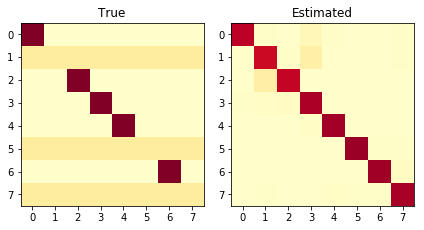

JS divergence: 0.2263	Norm Frobenius: 0.1825
Groups probabilities:  [0.0385 0.9615]


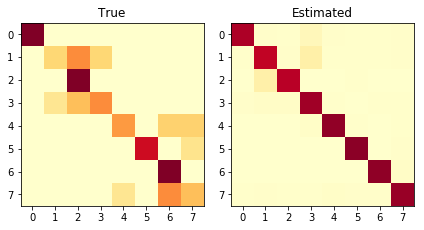

JS divergence: 0.1955	Norm Frobenius: 0.1801
Groups probabilities:  [0. 1.]
Calculate confusion matrix on global version


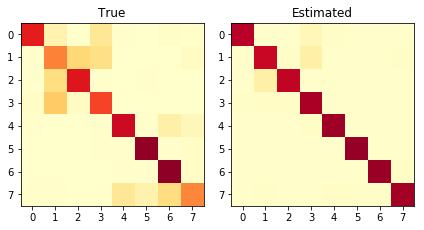

JS divergence: 0.0790	Norm Frobenius: 0.0987
A result


Accuracy  F1 (micro)  (R) NormF mean  (R) JS mean  (R) NormF w  \
0  All     0.824       0.824          0.1941        0.239       0.1477   

   (R) JS w  (G) NormF  (G) JS  RMSE mean  RMSE w  
0    0.1532     0.0987   0.079     0.1172  0.0899

A result


ACC imiting Annot mean  Cross-entropy mean  ACC imiting Annot wmean  \
0                  0.8081              0.5431                   0.8237   

   Cross entropy wmean  
0               0.4922

Test


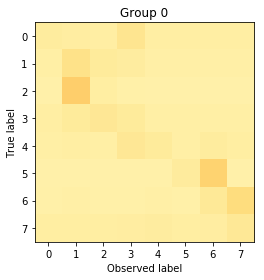

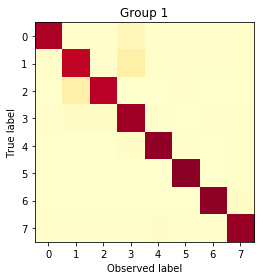

Inertia JS: 0.5392122828072333
Inertia NormF: 0.29820714265322495
A result


Groups    Prob  T(g)  Entropy  Diag mean  Isim (JS)  S_raykar  S_bias  \
0       0  0.0291     1   2.0466     0.1441     0.3116    0.0218  0.0232   
1       1  0.9709    57   0.3426     0.9281     0.9627    0.9178  0.0144   

   C_bias  Iner JS  Iner NormF  Accuracy  F1 (micro)  
0       1   0.5392      0.2982    0.2323      0.2323  
1       3   0.5392      0.2982    0.8165      0.8165

A result


Accuracy  F1 (micro)
0  All    0.8199      0.8199

In [20]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1') 
aux = gMixture_Ind3.calculate_extra_components(Xstd_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individua3l multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_I3 = flatten_conf(gMixture_Ind3.get_confusionM())

from sklearn.decomposition import PCA
model = PCA(2)

to_plot = model.fit_transform(to_plot)
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_I3 = model.transform(centroids_plot_I3)

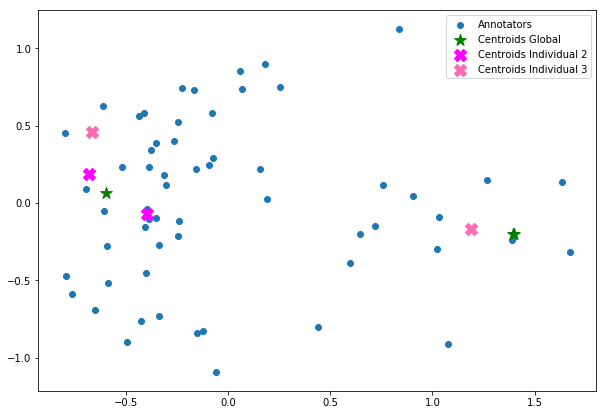

In [51]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Centroids Global")
plt.scatter(centroids_plot_I2[:,0], centroids_plot_I2[:,1],s=150, marker="X", color='magenta',label="Centroids Individual 2")
plt.scatter(centroids_plot_I3[:,0], centroids_plot_I3[:,1], s=150, marker="X", color='hotpink',label="Centroids Individual 3")

plt.legend()
plt.show()